# Parameter Optimization for Classification Models

This notebook compares the performance of k-Nearest Neighbors (kNN) and Logistic Regression algorithms on a classification task. The goal is to determine which algorithm performs better after optimizing their parameters using various hyperparameter tuning strategies.

The dataset contains 1000 samples with 35 features, and the task is to predict one of 3 possible class labels.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Standard library
import time
import numbers

# Core scientific stack
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Scikit-learn: model selection, metrics, preprocessing, pipelines
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.ensemble import StackingClassifier
from sklearn.feature_selection import SelectKBest, mutual_info_classif, RFE
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import (GridSearchCV, RandomizedSearchCV,
                                     StratifiedKFold, cross_val_score,
                                     learning_curve, validation_curve,
                                     train_test_split)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

# Optimization libraries: Optuna & Scikit-Optimize
from optuna.distributions import CategoricalDistribution, FloatDistribution, IntDistribution
from optuna.integration import OptunaSearchCV
from skopt import BayesSearchCV
from skopt.space import Categorical, Integer, Real

# Dimensionality reduction
from umap import UMAP

# PyTorch: tensors, models, datasets
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split


In [3]:
RANDOM_STATE = 0

In [4]:
sns.set(style="whitegrid", font_scale=1.2)
plt.rcParams.update({'figure.autolayout': True, 'axes.titlesize': 14, 'axes.labelsize': 12})

In [5]:
df = pd.read_csv('mldata_0003157425.csv')

# Data Exploration and Preprocessing

Before building and optimizing our models, let's explore the dataset to understand its characteristics, such as feature distributions, class balance, and potential correlations between features.

In [6]:
# Display basic information
print("Dataset Head")
print(df.head())

print(f"\nDataset Shape")
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")

print(f"\nDataset Info")
df.info()

print(f"\nMissing Values")
print(df.isnull().sum().sum()) # Total missing values

Dataset Head
   Unnamed: 0  label  feature_1  feature_2  feature_3  feature_4  feature_5  \
0           0      2   1.394040  -0.560729  -2.683595  -0.979726  -0.465095   
1           1      2   0.945826   2.013913   0.560470  -0.960273  -0.770016   
2           2      0   1.030214   0.235589  -0.222638  -0.116798  -0.985745   
3           3      1  -0.304264   0.550437   2.529918   0.164535  -1.013062   
4           4      1   0.361506   1.667298   3.127530  -0.015353  -0.036469   

   feature_6  feature_7  feature_8  ...  feature_26  feature_27  feature_28  \
0  -8.530843  -0.307211   0.338850  ...    1.570150   -0.862138    5.835569   
1   5.876345  -0.377342   0.048879  ...    0.385200    0.290089   -0.131663   
2  -4.585816   0.463274  -0.571512  ...    6.870866    1.945876    0.726195   
3  -0.590612  -0.339393  -0.189251  ...   -5.215602   -0.159240    1.202908   
4  10.065464  -0.481310  -1.113595  ...    2.348153    0.448138   -2.021718   

   feature_29  feature_30  feature_31

The dataset contains 1000 samples and 35 features. The head shows that the first column is the sample ID, the second column is the label, and the rest are numeric features. There are no missing values in the dataset.

In [7]:
sample_ids = df.index.tolist() # Store sample IDs for later use
X = df.drop(columns=['label', 'Unnamed: 0'])
y = df['label']
feature_names = X.columns.tolist()

print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Number of unique labels: {y.nunique()}")
print(f"Label values: {np.sort(y.unique())}")


Features shape: (1000, 35)
Target shape: (1000,)
Number of unique labels: 3
Label values: [0 1 2]


In [8]:
# Using nested cross-validation to evaluate the model, so we don't need to split the data again
X_train_val = X
y_train_val = y

print(f"\nShape of X_train_val: {X_train_val.shape}")
print(f"Shape of y_train_val: {y_train_val.shape}")

print("\nLabel distribution in original dataset:")
print(y.value_counts(normalize=True).sort_index())

print("\nLabel distribution in training/validation set:")
print(y_train_val.value_counts(normalize=True).sort_index())


Shape of X_train_val: (1000, 35)
Shape of y_train_val: (1000,)

Label distribution in original dataset:
label
0    0.343
1    0.325
2    0.332
Name: proportion, dtype: float64

Label distribution in training/validation set:
label
0    0.343
1    0.325
2    0.332
Name: proportion, dtype: float64


Summary Statistics for Features (X_train_val)
             count      mean       std        min       25%       50%  \
feature_1   1000.0  0.077874  0.989825  -3.100383 -0.534935  0.089912   
feature_2   1000.0  0.171867  2.312119  -6.037153 -1.328051  0.235152   
feature_3   1000.0  0.469450  2.437966  -6.977600 -1.150196  0.554915   
feature_4   1000.0 -0.017442  2.663865  -7.622472 -1.861193 -0.166811   
feature_5   1000.0  0.108823  1.002360  -3.444091 -0.569750  0.136728   
feature_6   1000.0  1.123164  5.663782 -20.949578 -2.594140  1.046486   
feature_7   1000.0  0.081289  1.002398  -2.762513 -0.546485  0.061618   
feature_8   1000.0  0.110151  0.980595  -2.866087 -0.562092  0.108780   
feature_9   1000.0  0.136127  1.029954  -3.419866 -0.548197  0.188460   
feature_10  1000.0  0.124670  1.029142  -3.963354 -0.567248  0.118029   
feature_11  1000.0  0.131314  1.024731  -3.115957 -0.567439  0.132818   
feature_12  1000.0  0.089518  2.385572  -8.468756 -1.535701  0.163840   
featu

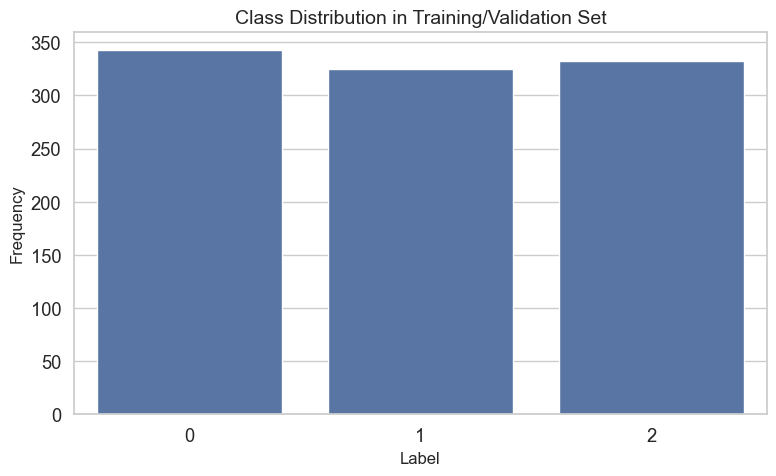

In [9]:
print("Summary Statistics for Features (X_train_val)")
print(X_train_val.describe().T)

plt.figure(figsize=(8, 5))
sns.countplot(x=y_train_val)
plt.title('Class Distribution in Training/Validation Set')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.show()

The class distribution shows that the dataset is fairly balanced across the three classes. This is good for training as it means we don't need to handle class imbalance. The summary statistics reveal the range and distribution of our features.

### Feature Distributions

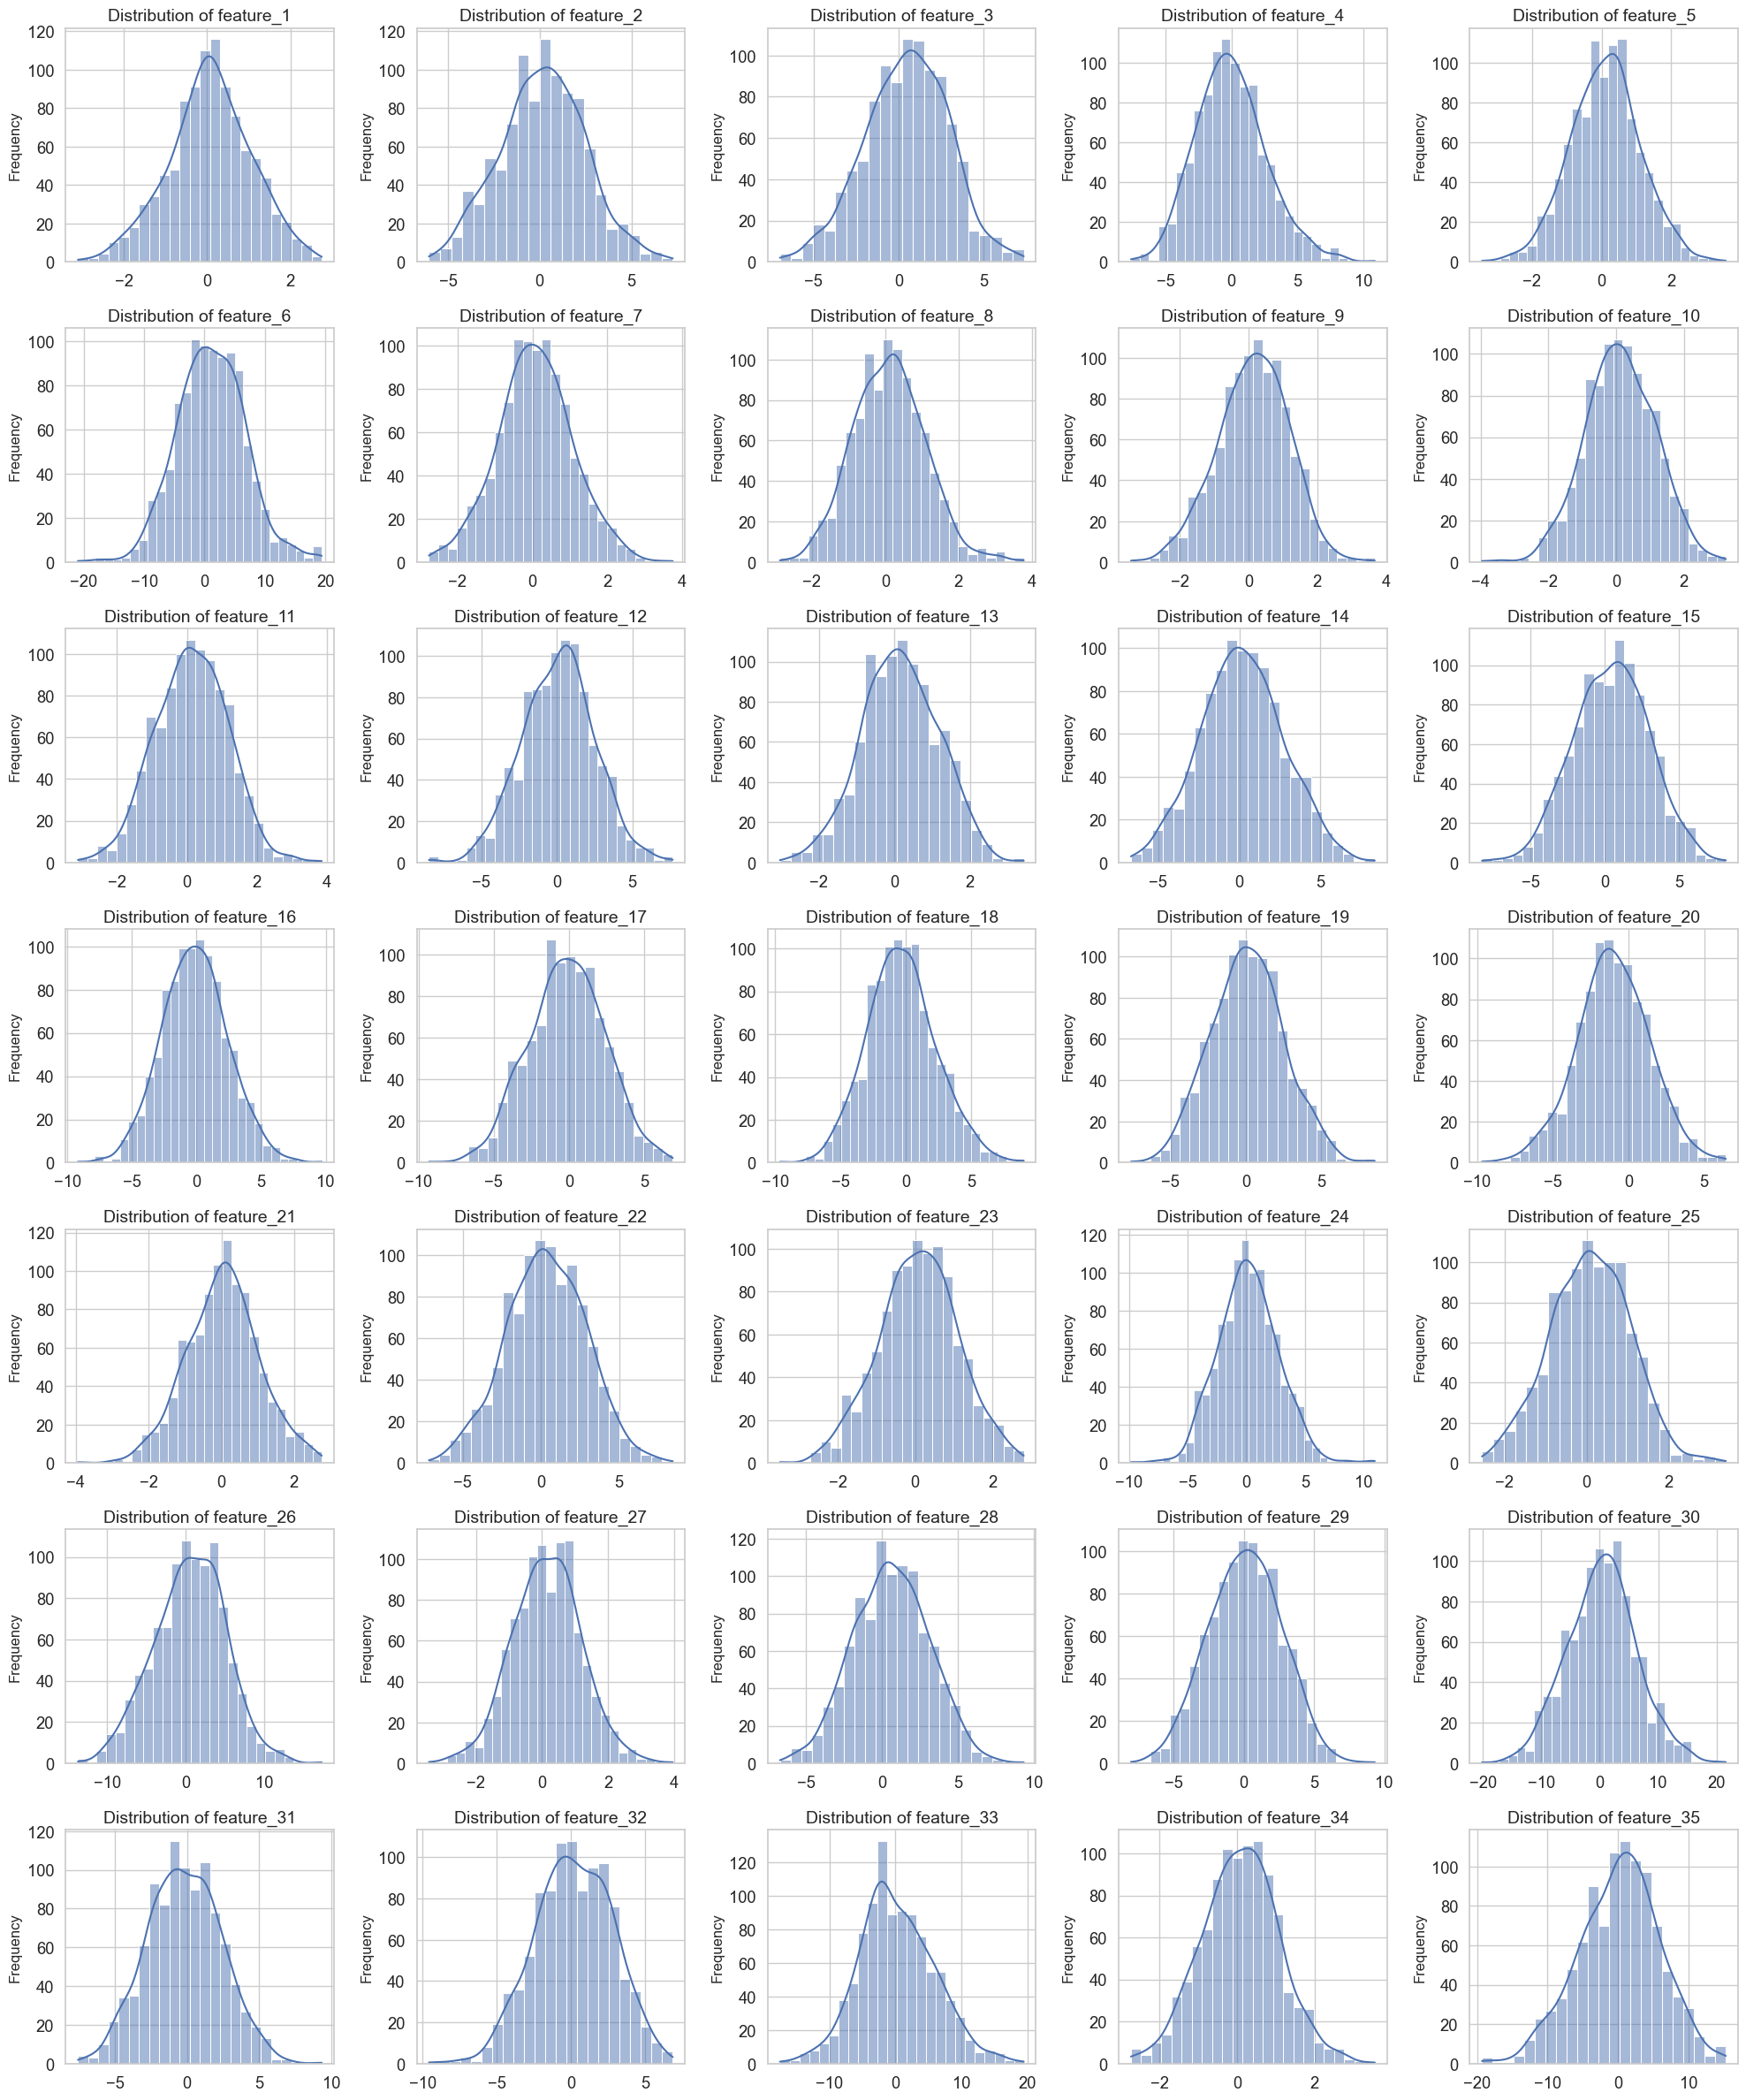

In [10]:
fig, axes = plt.subplots(nrows=7, ncols=5, figsize=(20, 24))
axes = axes.flatten()

for i, col in enumerate(X_train_val.columns[:35]):
    sns.histplot(X_train_val[col], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Frequency')

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

Most features appear to be normally distributed, which is beneficial for most machine learning algorithms.

### Feature Boxplots

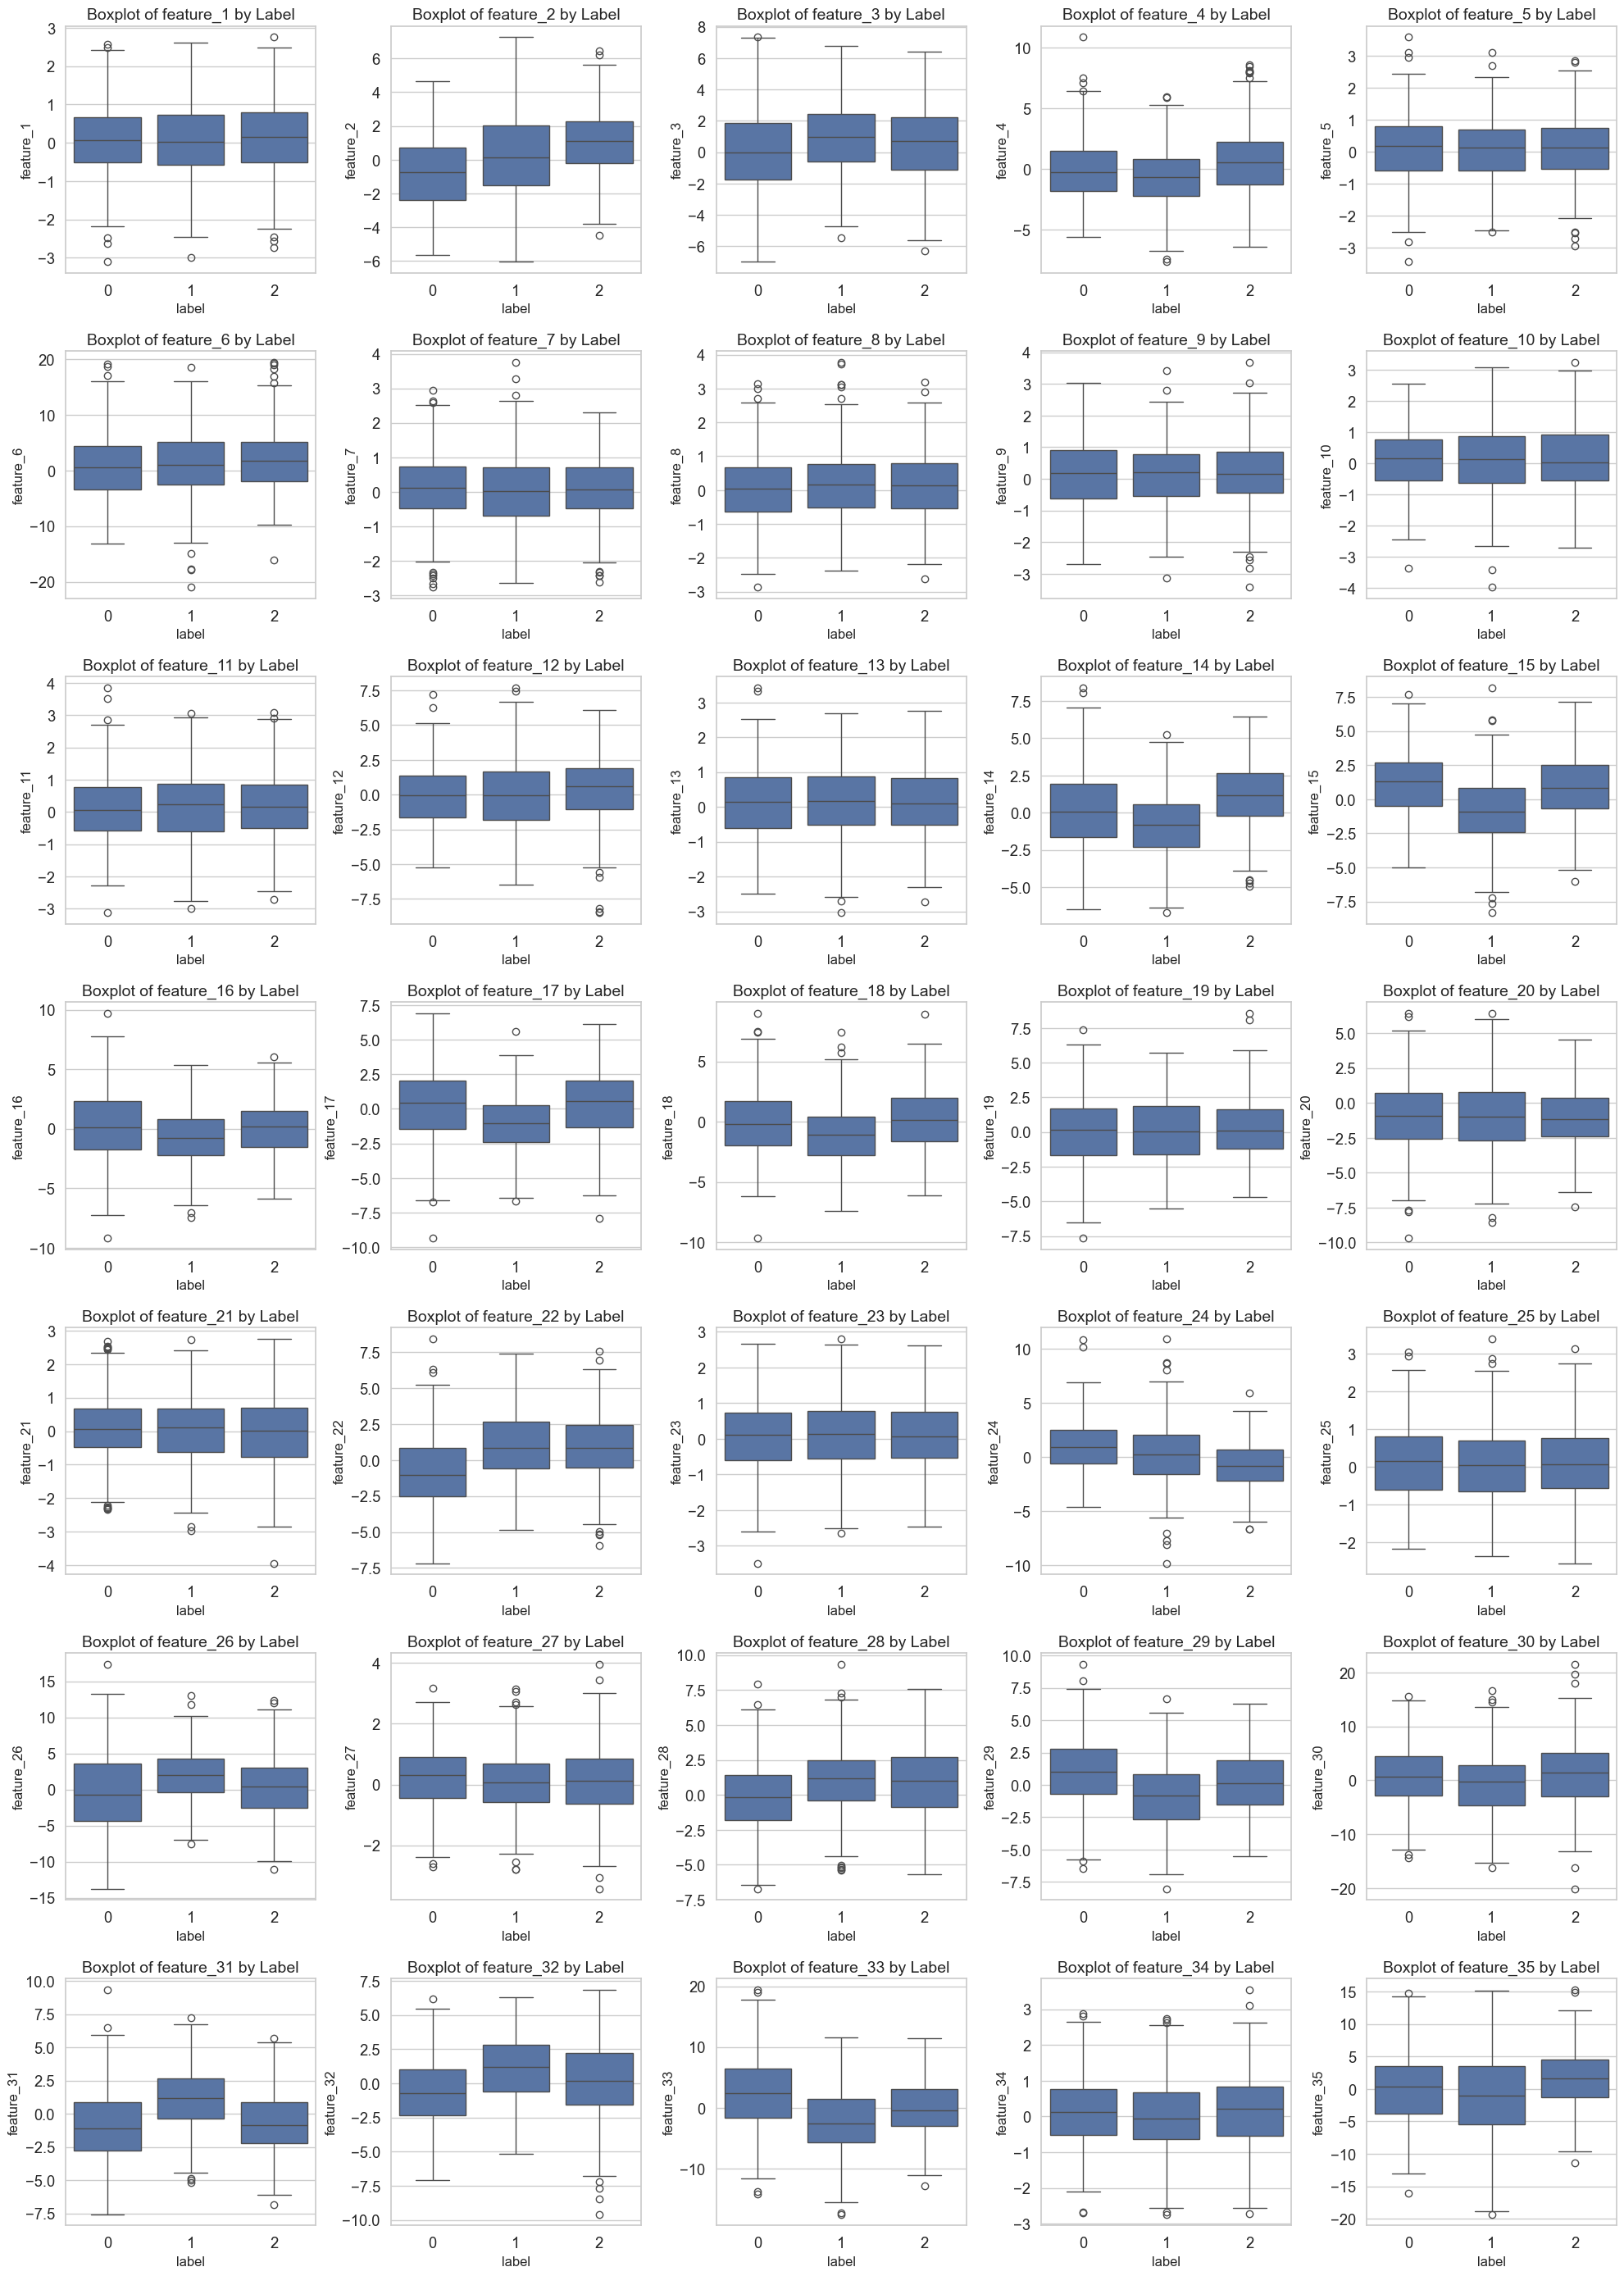

In [11]:
fig, axes = plt.subplots(nrows=7, ncols=5, figsize=(20, 28))
axes = axes.flatten()

temp_df = X_train_val.iloc[:, :35].copy()
temp_df['label'] = y_train_val.values

for i, col in enumerate(temp_df.columns[:-1]):
    sns.boxplot(x='label', y=col, data=temp_df, ax=axes[i])
    axes[i].set_title(f'Boxplot of {col} by Label')

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

Most of the features look equally distributed among the three classes, with only a few features showing some skewness. This suggests that the features are likely to be informative for classification.

Given the generally balanced class distribution and the normality of the features, we can proceed with building our classification models. 

### Correlation between variables

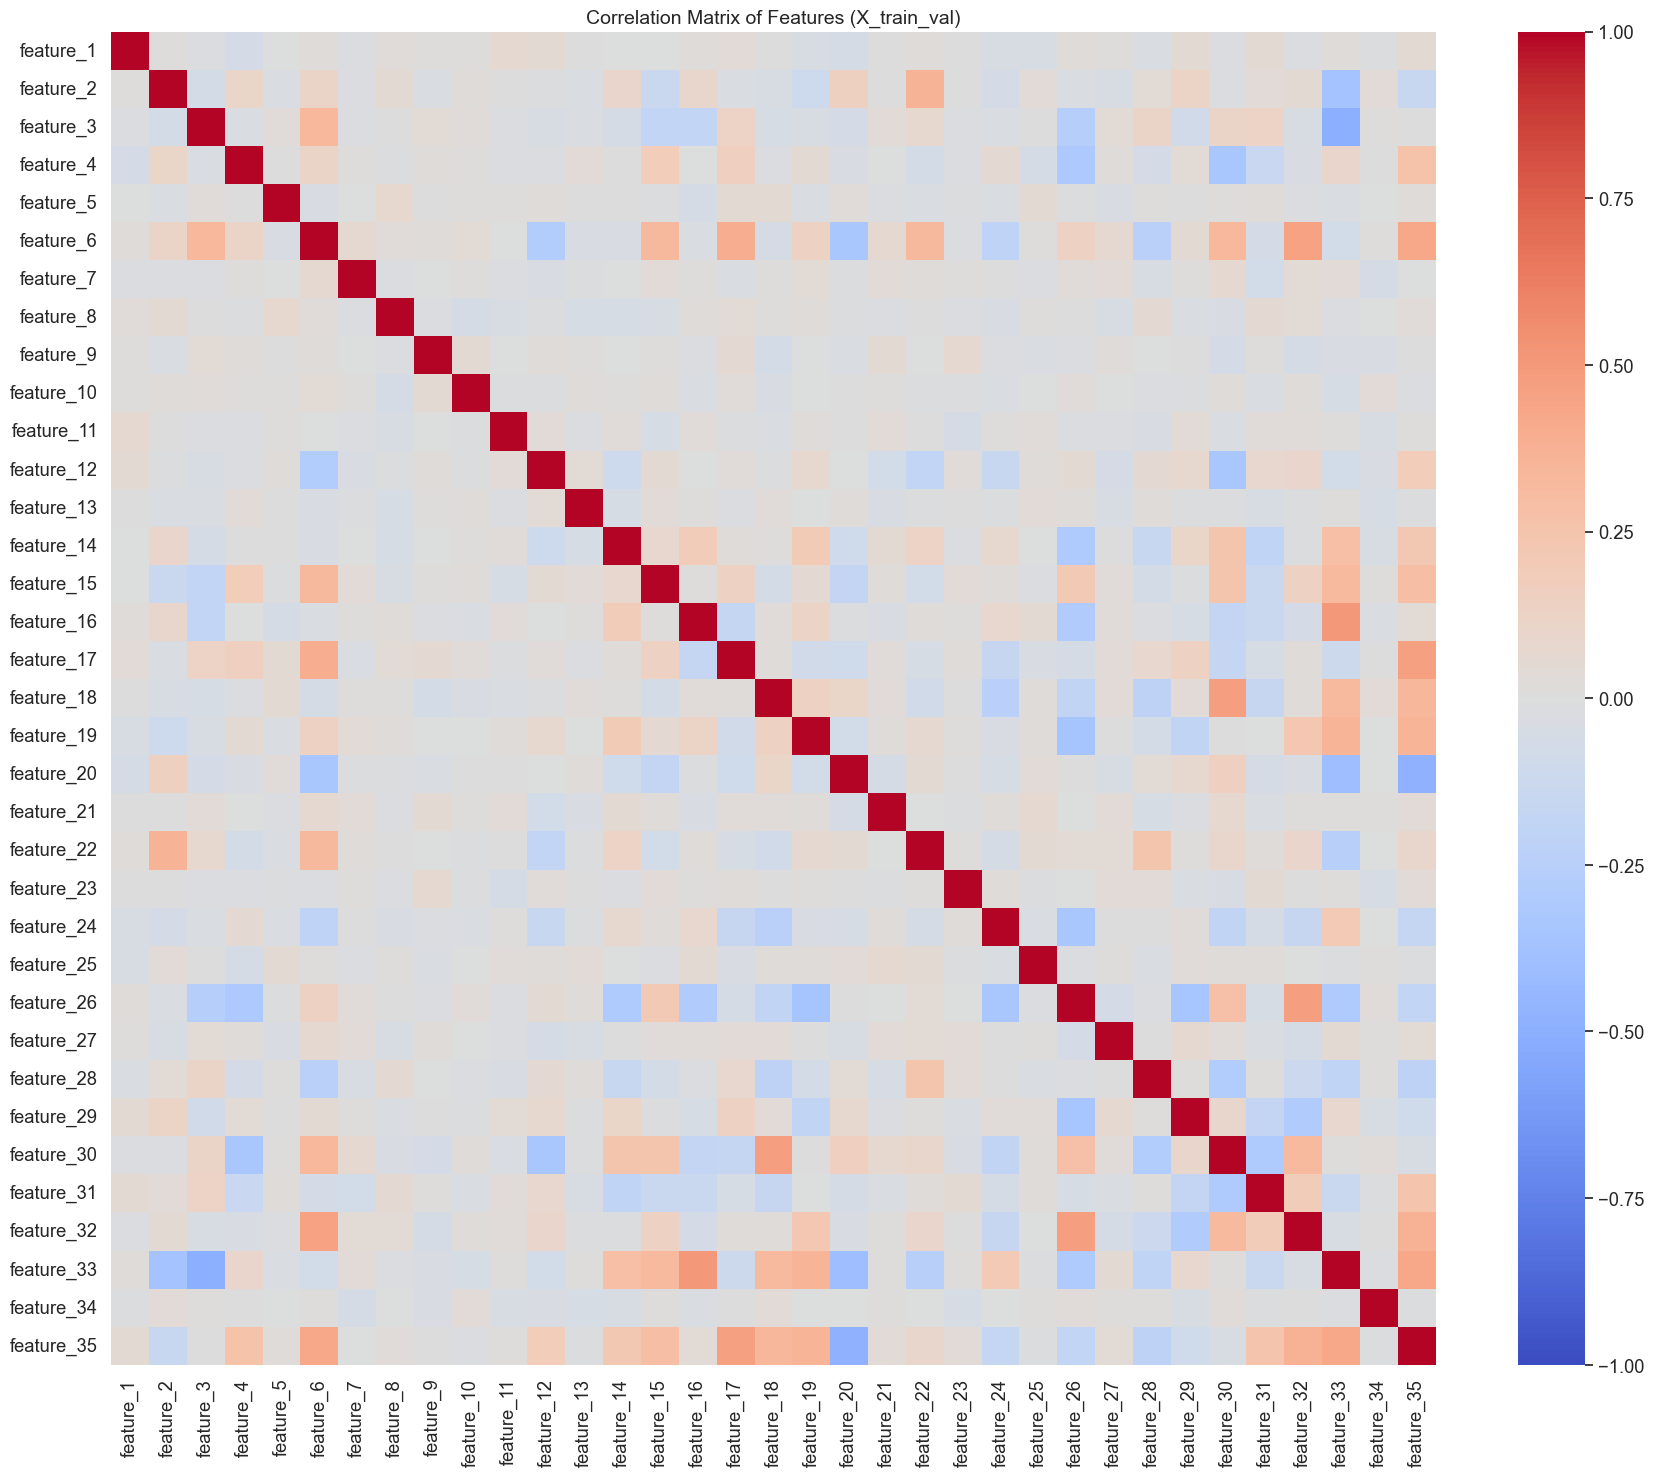


No feature pairs with absolute correlation > 0.8 found.


In [12]:
correlation_matrix = X_train_val.corr()
plt.figure(figsize=(18, 15))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Features (X_train_val)')
plt.show()

upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
highly_correlated_features = [(column, upper[column].abs().sort_values(ascending=False).index[0], upper[column].abs().sort_values(ascending=False).iloc[0])
                              for column in upper.columns if upper[column].abs().max() > 0.8]
if highly_correlated_features:
    print("\nHighly correlated feature pairs (absolute correlation > 0.8):")
    for f1, f2, corr_val in highly_correlated_features:
        print(f"{f1} and {f2}: {corr_val:.2f}")
else:
    print("\nNo feature pairs with absolute correlation > 0.8 found.")

The correlation matrix shows the relationships between features. While most features have low to moderate correlations with each other, there don't appear to be any extremely high correlations (above 0.8) that would suggest redundant features. This is beneficial as it means we likely don't need to remove features due to multicollinearity.

### T-SNE and UMAP Visualization

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


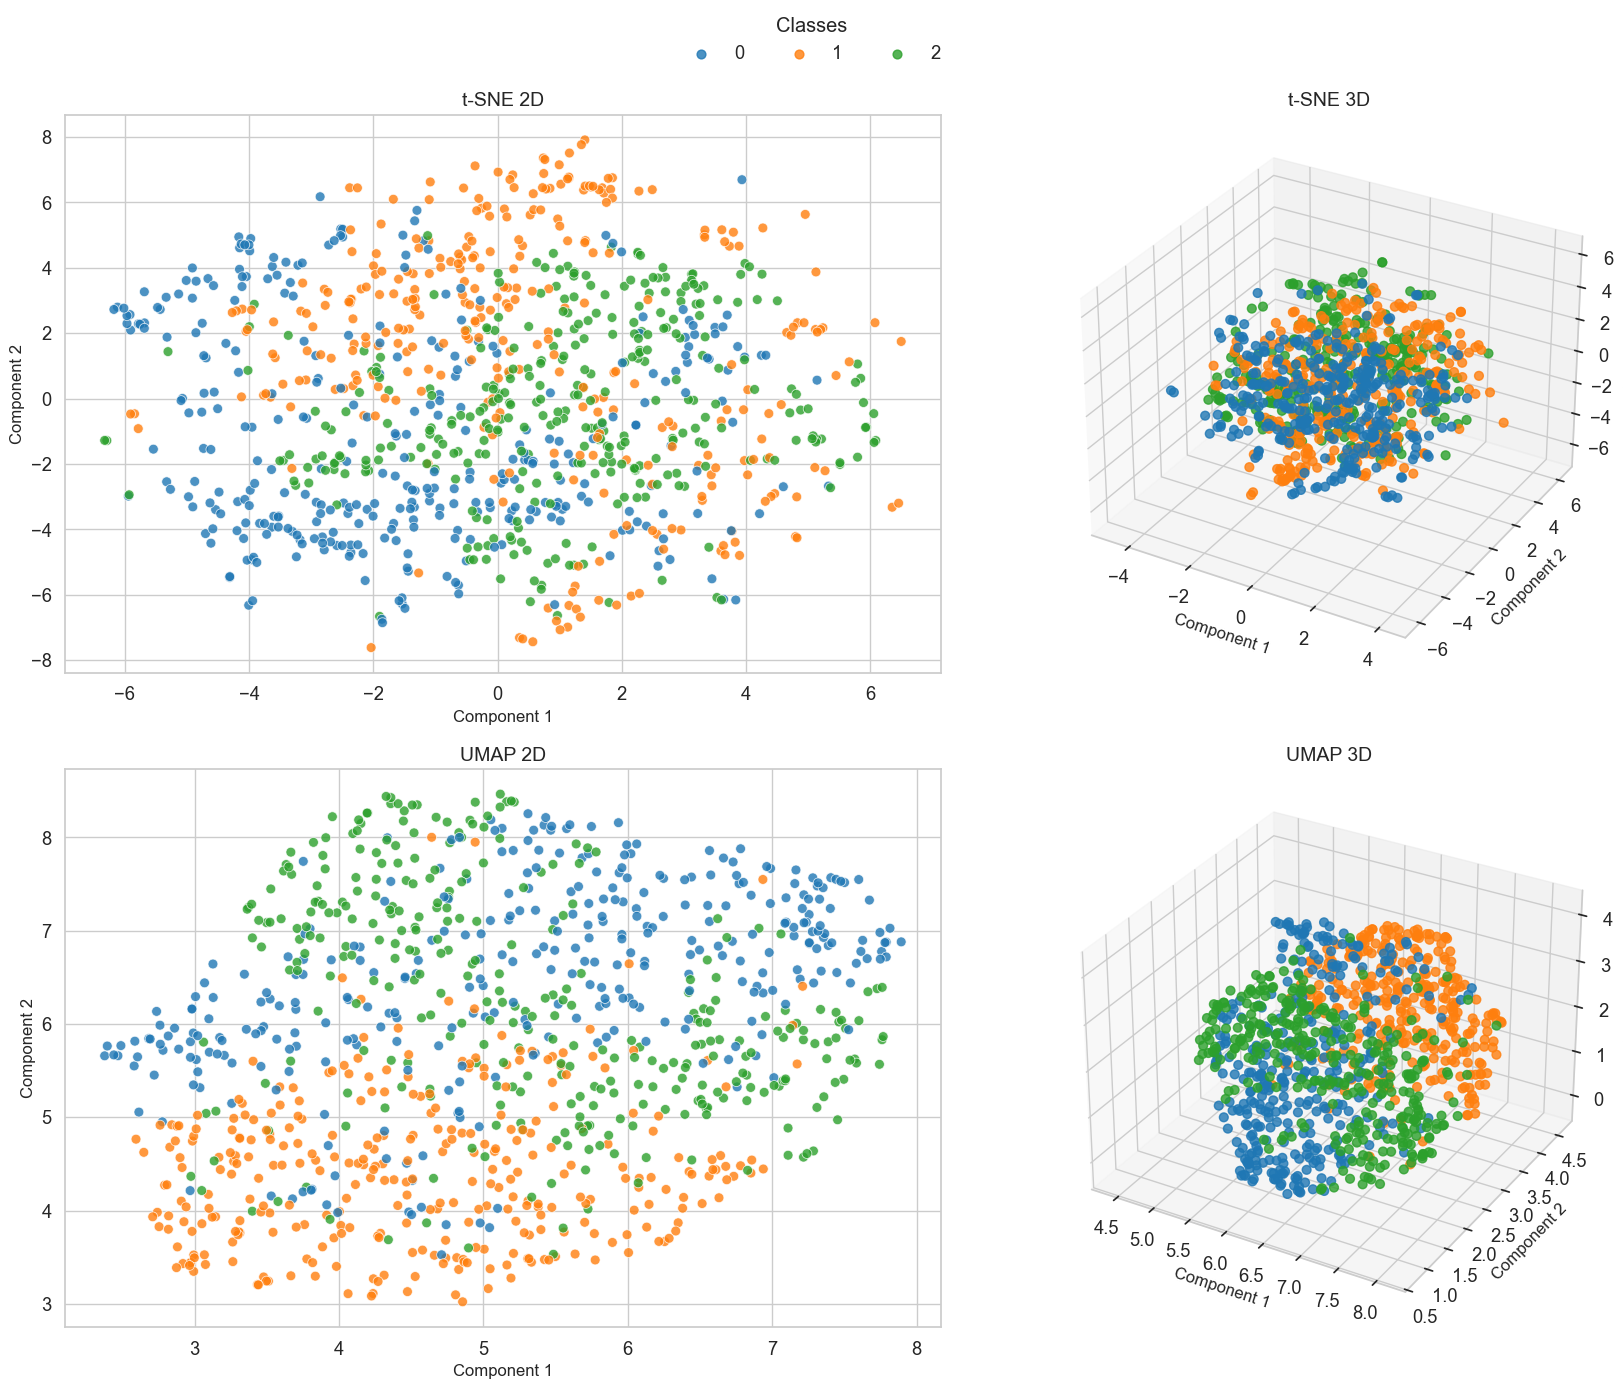

In [13]:
def plot_dimensionality_reduction(X, y, random_state=RANDOM_STATE):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    tsne_2d = TSNE(n_components=2, random_state=random_state, perplexity=30, n_iter=300)
    X_tsne_2d = tsne_2d.fit_transform(X_scaled)

    tsne_3d = TSNE(n_components=3, random_state=random_state, perplexity=30, n_iter=300)
    X_tsne_3d = tsne_3d.fit_transform(X_scaled)

    umap_2d = UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=random_state)
    X_umap_2d = umap_2d.fit_transform(X_scaled)

    umap_3d = UMAP(n_components=3, n_neighbors=15, min_dist=0.1, random_state=random_state)
    X_umap_3d = umap_3d.fit_transform(X_scaled)

    colors = sns.color_palette("tab10", n_colors=np.unique(y).size)
    fig = plt.figure(figsize=(18, 14))

    ax1 = fig.add_subplot(2, 2, 1)
    sns.scatterplot(x=X_tsne_2d[:, 0], y=X_tsne_2d[:, 1], hue=y, palette=colors, legend=False, ax=ax1, s=50, alpha=0.8)
    ax1.set(title="t-SNE 2D", xlabel="Component 1", ylabel="Component 2")

    ax2 = fig.add_subplot(2, 2, 2, projection='3d')
    for i, label in enumerate(np.unique(y)):
        idx = y == label
        ax2.scatter(X_tsne_3d[idx, 0], X_tsne_3d[idx, 1], X_tsne_3d[idx, 2], color=colors[i], label=label, s=40, alpha=0.8)
    ax2.set(title="t-SNE 3D", xlabel="Component 1", ylabel="Component 2", zlabel="Component 3")

    ax3 = fig.add_subplot(2, 2, 3)
    sns.scatterplot(x=X_umap_2d[:, 0], y=X_umap_2d[:, 1], hue=y, palette=colors, legend=False, ax=ax3, s=50, alpha=0.8)
    ax3.set(title="UMAP 2D", xlabel="Component 1", ylabel="Component 2")

    ax4 = fig.add_subplot(2, 2, 4, projection='3d')
    for i, label in enumerate(np.unique(y)):
        idx = y == label
        ax4.scatter(X_umap_3d[idx, 0], X_umap_3d[idx, 1], X_umap_3d[idx, 2], color=colors[i], label=label, s=40, alpha=0.8)
    ax4.set(title="UMAP 3D", xlabel="Component 1", ylabel="Component 2", zlabel="Component 3")

    handles, labels = ax4.get_legend_handles_labels()
    fig.legend(handles, labels, title="Classes", loc='upper center', ncol=6, frameon=False)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

plot_dimensionality_reduction(X_train_val, y_train_val)

The dimensionality reduction visualizations using t-SNE and UMAP provide insights into how well the classes can be separated in lower-dimensional space. The plots show that the classes have some degree of separation, which is encouraging for our classification task. The visualizations suggest that the data has an inherent structure that our models can potentially capture.

### PCA: Explained Variance Analysis

Let's analyze how the variance is distributed across the principal components. This will help us understand how many components we need to retain most of the information in the dataset, which is valuable for dimensionality reduction.

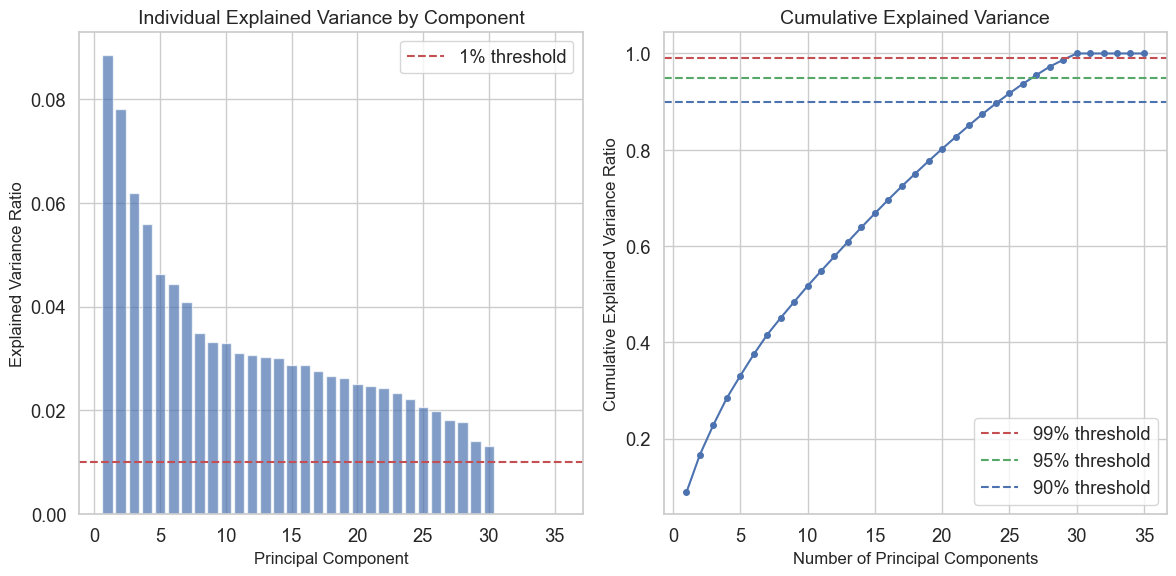

Number of principal components needed to explain:
80% of variance: 20 components
90% of variance: 25 components
95% of variance: 27 components
99% of variance: 30 components


In [14]:
# Standardize the data for PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train_val)

# Perform PCA to analyze explained variance
pca = PCA()
pca.fit(X_scaled)

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot the explained variance
plt.figure(figsize=(12, 6))

# Individual explained variance
plt.subplot(1, 2, 1)
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, alpha=0.7)
plt.axhline(y=0.01, color='r', linestyle='--', label='1% threshold')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Individual Explained Variance by Component')
plt.legend()

# Cumulative explained variance
plt.subplot(1, 2, 2)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'o-', markersize=4)
plt.axhline(y=0.99, color='r', linestyle='--', label='99% threshold')
plt.axhline(y=0.95, color='g', linestyle='--', label='95% threshold')
plt.axhline(y=0.90, color='b', linestyle='--', label='90% threshold')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance')
plt.legend()

plt.tight_layout()
plt.show()

# Find how many components are needed for different variance thresholds
thresholds = [0.80, 0.90, 0.95, 0.99]
components_needed = [np.argmax(cumulative_variance >= t) + 1 for t in thresholds]

print("Number of principal components needed to explain:")
for t, c in zip(thresholds, components_needed):
    print(f"{t*100:.0f}% of variance: {c} components")

The PCA shows that the last 5 components have no explained variance, indicating that they do not contribute significantly to the dataset's information. This suggests that we can reduce the dimensionality of our dataset without losing much information by retaining only the first 30 components.

Howerver, since the features are anonymous and no domain knowledge is available, it is better to keep all 30 features for the classification task. This will allow the models to utilize all available information without making assumptions about feature importance. Only the 5 components with no explained variance can be dropped.

## Hyperparameter Optimization

In this section, we'll compare different approaches to hyperparameter optimization for both kNN and Logistic Regression models. We'll use various strategies including:

1. Grid Search (exhaustive search)
2. Random Search (random sampling)
3. Optuna (Bayesian optimization with pruning)
4. Bayesian Optimization (sequential model-based optimization)

We'll evaluate these strategies based on both performance (accuracy) and computational efficiency (time taken).

#### Helper Functions

The first cell defines helper functions for model evaluation which will be explained in detail later. The second cell defines function to convert parameter grids into a format suitable for hyperparameter optimization libraries like Optuna and Bayesian Optimization.

In [15]:
def compare_validation_curves(ax1, ax2, estimator1, estimator2, name1, name2, 
                              param1_name, param1_range, param2_name, param2_range,
                              X, y, cv, scoring='accuracy'):
    for ax, est, name, pname, prange in zip(
        [ax1, ax2], [estimator1, estimator2], [name1, name2], [param1_name, param2_name], [param1_range, param2_range]):

        train_scores, test_scores = validation_curve(
            est, X, y, param_name=pname, param_range=prange, cv=cv, scoring=scoring, n_jobs=-1
        )
        train_mean, test_mean = np.mean(train_scores, axis=1), np.mean(test_scores, axis=1)

        plot_func = ax.semilogx if np.issubdtype(np.array(prange).dtype, np.number) and \
            (np.max(prange) / np.min(prange) > 10 if np.min(prange) > 0 else False) else ax.plot

        plot_func(prange, train_mean, label='Training score', marker='o')
        plot_func(prange, test_mean, label='Cross-validation score', marker='o')

        ax.set(title=f'{name} — {pname.split("__")[-1]}', xlabel=pname.split("__")[-1], ylabel=scoring.capitalize())
        ax.grid(True)
        ax.legend(loc='best')

def compare_learning_curves(ax1, ax2, estimator1, estimator2, name1, name2, X, y, cv, scoring='accuracy'):
    train_sizes = np.linspace(0.1, 1.0, 5)
    for ax, est, name in zip([ax1, ax2], [estimator1, estimator2], [name1, name2]):
        sizes, train_scores, test_scores = learning_curve(est, X, y, cv=cv, scoring=scoring, n_jobs=-1, train_sizes=train_sizes)
        train_mean, train_std = np.mean(train_scores, axis=1), np.std(train_scores, axis=1)
        test_mean, test_std = np.mean(test_scores, axis=1), np.std(test_scores, axis=1)

        ax.plot(sizes, train_mean, 'o-', label='Training score')
        ax.plot(sizes, test_mean, 'o-', label='Cross-validation score')
        ax.fill_between(sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
        ax.fill_between(sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
        ax.set(title=f'Learning Curve: {name}', xlabel="Training examples", ylabel=scoring.capitalize())
        ax.grid(True)
        ax.legend(loc='best')

def nested_cv_plots(ax1, ax2, grid1, grid2, title1, title2, cv_outer, X, y):
    records1, records2 = [], []
    for train_idx, test_idx in cv_outer.split(X, y):
        X_tr, y_tr = X.iloc[train_idx], y.iloc[train_idx]
        X_te, y_te = X.iloc[test_idx], y.iloc[test_idx]
        grid1.fit(X_tr, y_tr)
        grid2.fit(X_tr, y_tr)
        records1.append({'mean_inner_cv_score': grid1.best_score_, 'test_score': grid1.best_estimator_.score(X_te, y_te)})
        records2.append({'mean_inner_cv_score': grid2.best_score_, 'test_score': grid2.best_estimator_.score(X_te, y_te)})

    df1, df2 = pd.DataFrame(records1), pd.DataFrame(records2)
    sns.regplot(x='mean_inner_cv_score', y='test_score', data=df1, ax=ax1, scatter_kws={'s': 50})
    sns.regplot(x='mean_inner_cv_score', y='test_score', data=df2, ax=ax2, scatter_kws={'s': 50})
    ax1.set_title(title1)
    ax2.set_title(title2)

def compare_all_plots(estimator1, estimator2, name1, name2,
                      param1_name, param1_range, param2_name, param2_range,
                      X, y, cv_inner, cv_outer, grid1, grid2,
                      nested_title1, nested_title2, scoring='accuracy'):
    fig, axes = plt.subplots(3, 2, figsize=(18, 18), sharey='row')
    compare_validation_curves(axes[0, 0], axes[0, 1], estimator1, estimator2, name1, name2,
                              param1_name, param1_range, param2_name, param2_range, X, y, cv_inner, scoring)
    compare_learning_curves(axes[1, 0], axes[1, 1], estimator1, estimator2, name1, name2,
                            X, y, cv_inner, scoring)
    nested_cv_plots(axes[2, 0], axes[2, 1], grid1, grid2, nested_title1, nested_title2, cv_outer, X, y)
    plt.tight_layout()
    plt.show()

In [16]:
# Functions to convert parameter grids for different libraries
def convert_param_grid_to_skopt(param_grid):
    """Convert a parameter grid to a format suitable for skopt's BayesSearchCV."""
    def to_space(grid):
        ss = {}
        for p, vals in grid.items():
            v = list(vals)
            if all(isinstance(x, numbers.Integral) for x in v):
                lo, hi = min(v), max(v)
                ss[p] = Integer(lo, hi) if len(v) > 2 else Categorical(v)
            elif all(isinstance(x, numbers.Real) for x in v):
                lo, hi = min(v), max(v)
                ss[p] = Real(lo, hi) if len(v) > 3 else Categorical(v)
            else:
                ss[p] = Categorical(v)
        return ss

    if isinstance(param_grid, list):
        return [to_space(g) for g in param_grid]
    return to_space(param_grid)

def convert_param_grid_to_optuna(param_grid):
    """Convert a parameter grid to a format suitable for Optuna's OptunaSearchCV."""
    if isinstance(param_grid, list):
        merged = {}
        for g in param_grid:
            for k, v in g.items():
                merged.setdefault(k, []).extend(v)
        param_grid = {k: list(set(v)) for k, v in merged.items()}

    optuna_space = {}
    for p, vals in param_grid.items():
        v = list(vals)
        if all(isinstance(x, numbers.Integral) for x in v):
            lo, hi = min(v), max(v)
            optuna_space[p] = (
                IntDistribution(lo, hi)
                if len(v) > 2
                else CategoricalDistribution(v)
            )
        elif all(isinstance(x, numbers.Real) for x in v):
            lo, hi = min(v), max(v)
            optuna_space[p] = (
                FloatDistribution(lo, hi)
                if len(v) > 3
                else CategoricalDistribution(v)
            )
        else:
            optuna_space[p] = CategoricalDistribution(v)
    return optuna_space

### Hyperparameter Tuning Setup

A nested cross-validation approach is implemented:
- Outer CV (5 folds): For unbiased evaluation of model performance on truly unseen data
- Inner CV (5 folds): For hyperparameter tuning

This setup helps avoid overfitting to the validation set during hyperparameter tuning and provides a more reliable estimate of model performance.

Additionally, PCA-related hyperparameters have been incorporated to control dimensionality reduction:
- `PCA`: Boolean flag to determine whether to apply PCA before training the models
- `EXPLAINED_VARIANCE`: The target amount of variance to retain (default: 0.99)

As explaine earlier, PCA is only applied to remove the last 5 components with no explained variance, so the `EXPLAINED_VARIANCE` parameter is set to 0.99 to retain most of the information in the dataset.

In [17]:
N_CV_OUTER = 5  # Number of folds for outer cross-validation (evaluation)
N_CV_INNER = 5  # Number of folds for inner cross-validation (hyperparameter tuning)
N_ITER_RANDOM = 50 # Number of iterations for RandomizedSearchCV and BayesSearchCV
N_ITER_BAYES = 10 # Number of iterations for BayesSearchCV
N_TRIALS_OPTUNA = 20 # Number of trials for Optuna

# PCA parameters
USE_PCA = True  # Whether to use PCA for dimensionality reduction
EXPLAINED_VARIANCE = 0.99  # Amount of variance to retain when using PCA

In [18]:
# Cross validation strategy
cv_outer = StratifiedKFold(n_splits=N_CV_OUTER, shuffle=True, random_state=RANDOM_STATE)
cv_inner = StratifiedKFold(n_splits=N_CV_INNER, shuffle=True, random_state=RANDOM_STATE)

In [19]:
if USE_PCA:
    pca = PCA(n_components=EXPLAINED_VARIANCE, random_state=RANDOM_STATE)
    X_train_val_pca = pca.fit_transform(X_scaled)
    print(f"\nShape of X_train_val after PCA: {X_train_val_pca.shape}")
    X_train_val = pd.DataFrame(X_train_val_pca, columns=[f'PC{i+1}' for i in range(X_train_val_pca.shape[1])])


Shape of X_train_val after PCA: (1000, 30)


#### Parameter Search Spaces

For the kNN classifier, we're exploring:
- Number of neighbors (n_neighbors)
- Weighting method (uniform or distance)
- Distance metric (euclidean, manhattan, etc.)

For Logistic Regression, we're exploring:
- Regularization type (L1, L2, elasticnet)
- Regularization strength (C parameter)
- Solver algorithm (saga, newton-cg, lbfgs)
- Fit intercept option

These parameter grids are converted to appropriate formats for each optimization library.

In [20]:
results_summary = [] # To store (model_name, strategy_name, time, candidates, mean_score, std_score)

# k-Nearest Neighbors (kNN)
knn_pipeline = Pipeline([
    ('knn', KNeighborsClassifier(n_jobs=-1))
])

# kNN Parameter Grid/Spaces
knn_param_grid = {
    'knn__n_neighbors': [1, 2, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 24, 27, 30, 35, 40, 45, 50, 60, 75, 100],
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan', 'minkowski', 'chebyshev'],
    'knn__p': [1, 1.5, 2],# 3, 4],  # `p` is only used for minkowski
    'knn__algorithm': ['auto']
}
knn_param_grid_skopt = convert_param_grid_to_skopt(knn_param_grid)
knn_param_grid_optuna = convert_param_grid_to_optuna(knn_param_grid)


# Logistic Regression
logreg_pipeline = Pipeline([
    ('logreg', LogisticRegression(random_state=RANDOM_STATE, n_jobs=-1))
])

# Logistic Regression Parameter Grid/Spaces
C = np.logspace(-6, 6, 20)
tol = np.logspace(-8, -2, num=4)
logreg_param_grid = [
    {
        'logreg__penalty': ['l1'],
        'logreg__solver': ['saga'],
        'logreg__C': C,
        'logreg__max_iter': [100000],
        'logreg__fit_intercept': [True, False],
        #'logreg__tol': tol,
    },
    {
        'logreg__penalty': ['l2'],
        'logreg__solver': ['saga', 'newton-cg', 'lbfgs'],
        'logreg__C': C,
        'logreg__max_iter': [100000],
        'logreg__fit_intercept': [True, False],
        #'logreg__tol': tol,
    },
    {
        'logreg__penalty': ['elasticnet'],
        'logreg__solver': ['saga'],
        'logreg__C': C,
        'logreg__max_iter': [100000],
        'logreg__l1_ratio': [0.1, 0.5, 0.9],
        'logreg__fit_intercept': [True, False],
        #'logreg__tol': tol,
    },
]

logreg_param_grid_skopt = convert_param_grid_to_skopt(logreg_param_grid)
logreg_param_grid_optuna = {
    # only solvers that support both L1 and L2
    'logreg__solver': CategoricalDistribution(['saga']),
    'logreg__penalty': CategoricalDistribution(['l1', 'l2']),
    'logreg__C': FloatDistribution(1e-3, 1e3),
    'logreg__fit_intercept': CategoricalDistribution([True, False]),
    #'logreg__tol': FloatDistribution(1e-6, 1e-1)
}

In [21]:
n_candidates_grid_knn = np.prod([len(v) for v in knn_param_grid.values()]) * N_CV_INNER
print(f"kNN (considering CV): {n_candidates_grid_knn} candidates")

n_candidates_grid_logreg = 0
for param_dict in logreg_param_grid:
    n_combinations = 1
    for v in param_dict.values():
        n_combinations *= len(v)
    n_candidates_grid_logreg += n_combinations

n_candidates_grid_logreg *= N_CV_INNER
print(f"Logistic Regression (considering CV): {n_candidates_grid_logreg} candidates")

kNN (considering CV): 2640 candidates
Logistic Regression (considering CV): 1400 candidates


The calculation shows the total number of model evaluations required for grid search, considering all possible parameter combinations and cross-validation folds. Both or kNN and Logistic Regression, this means evaluating thousands of models and highlights why more efficient search strategies might be preferable.

## Comparison of Optimization Strategies

Each optimisation strategy is summarised by a 3 × 2 grid of plots that puts the two classifiers side-by-side:

| Row                                                                                                                    | Information conveyed                                                                                                                                                                                   | Why it matters |
| ---------------------------------------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ | -------------- |
| **Validation curves (top)** Accuracy against the main hyper-parameter (`n_neighbors` for k-NN, `C` for Logistic Reg.). | Reveals the bias–variance trade-off and the location of the best hyper-parameter value.                                                                                                                | Helps choose the right complexity: too low or too high leads to under- or overfitting. |
| **Learning curves (middle)** Accuracy vs. number of training examples.                                                 | Shows how much each model profits from more data, and whether the gap between training and validation scores is due to high variance (over-fit) or high bias (under-fit).                              | Informs whether collecting more data is worthwhile and what kind of model adjustment is needed. |
| **Nested-CV scatter (bottom)** Inner CV score vs. outer test score across the folds of a nested cross-validation.      | Detects over-optimism: points below the diagonal regression line indicate that the inner loop over-estimates generalisation performance. The slope and spread give an empirical estimate of stability. | Indicates how trustworthy the model selection process is and whether the model generalises reliably. |

Analyzing all three rows simultaneously allows for assessment of 
- the absolute performance of each model
- its robustness to data size
- the reliability of the selected hyper-parameters under genuine "unseen" data.


### Baseline Models

We first evaluate both algorithms with their default parameters to establish a baseline performance. This gives us a reference point to measure the improvements achieved through hyperparameter optimization.

In [22]:
start_time = time.perf_counter()
baseline_knn_scores = cross_val_score(knn_pipeline, X_train_val, y_train_val, cv=cv_outer, scoring='accuracy', n_jobs=-1)
time_taken = time.perf_counter() - start_time
results_summary.append({
    'model': 'kNN', 'strategy': 'Baseline', 'time': time_taken, 'candidates': 1,
    'mean_score': np.mean(baseline_knn_scores), 'std_score': np.std(baseline_knn_scores), 'best_params': 'default'
})
print(f"kNN Baseline: Mean Acc={np.mean(baseline_knn_scores):.4f} +/- {np.std(baseline_knn_scores):.4f}, Time={time_taken:.2f}s")


kNN Baseline: Mean Acc=0.7760 +/- 0.0368, Time=1.50s


In [23]:
start_time = time.perf_counter()
baseline_logreg_scores = cross_val_score(logreg_pipeline, X_train_val, y_train_val, cv=cv_outer, scoring='accuracy', n_jobs=-1)
time_taken = time.perf_counter() - start_time
results_summary.append({
    'model': 'LogReg', 'strategy': 'Baseline', 'time': time_taken, 'candidates': 1,
    'mean_score': np.mean(baseline_logreg_scores), 'std_score': np.std(baseline_logreg_scores), 'best_params': 'default'
})
print(f"LogReg Baseline: Mean Acc={np.mean(baseline_logreg_scores):.4f} +/- {np.std(baseline_logreg_scores):.4f}, Time={time_taken:.2f}s")


LogReg Baseline: Mean Acc=0.7020 +/- 0.0216, Time=0.66s


Looking at the baseline performance, kNN looks more promising than Logistic Regression.

### Grid Search

Grid Search exhaustively evaluates all possible parameter combinations in the search space. While computationally expensive, it provides a thorough exploration of the parameter space.

In [24]:
grid_search_knn = GridSearchCV(knn_pipeline, knn_param_grid, cv=cv_inner, scoring='accuracy', n_jobs=-1)
start_time = time.perf_counter()
grid_search_knn.fit(X_train_val, y_train_val)
time_taken = time.perf_counter() - start_time
results_summary.append({
    'model': 'kNN', 'strategy': 'GridSearchCV', 'time': time_taken, 'candidates': n_candidates_grid_knn,
    'mean_score': grid_search_knn.best_score_, 'std_score': grid_search_knn.cv_results_['std_test_score'][grid_search_knn.best_index_],
    'best_params': grid_search_knn.best_params_
})
print(f"kNN GridSearchCV: Best Acc={grid_search_knn.best_score_:.4f}, Time={time_taken:.2f}s")

kNN GridSearchCV: Best Acc=0.8260, Time=5.69s


In [25]:
grid_search_logreg = GridSearchCV(logreg_pipeline, logreg_param_grid, cv=cv_inner, scoring='accuracy', n_jobs=-1)
start_time = time.perf_counter()
grid_search_logreg.fit(X_train_val, y_train_val)
time_taken = time.perf_counter() - start_time
results_summary.append({
    'model': 'LogReg', 'strategy': 'GridSearchCV', 'time': time_taken, 'candidates': n_candidates_grid_logreg,
    'mean_score': grid_search_logreg.best_score_, 'std_score': grid_search_logreg.cv_results_['std_test_score'][grid_search_logreg.best_index_],
    'best_params': grid_search_logreg.best_params_
})
print(f"LogReg GridSearchCV: Best Acc={grid_search_logreg.best_score_:.4f}, Time={time_taken:.2f}s")

LogReg GridSearchCV: Best Acc=0.7150, Time=8.86s


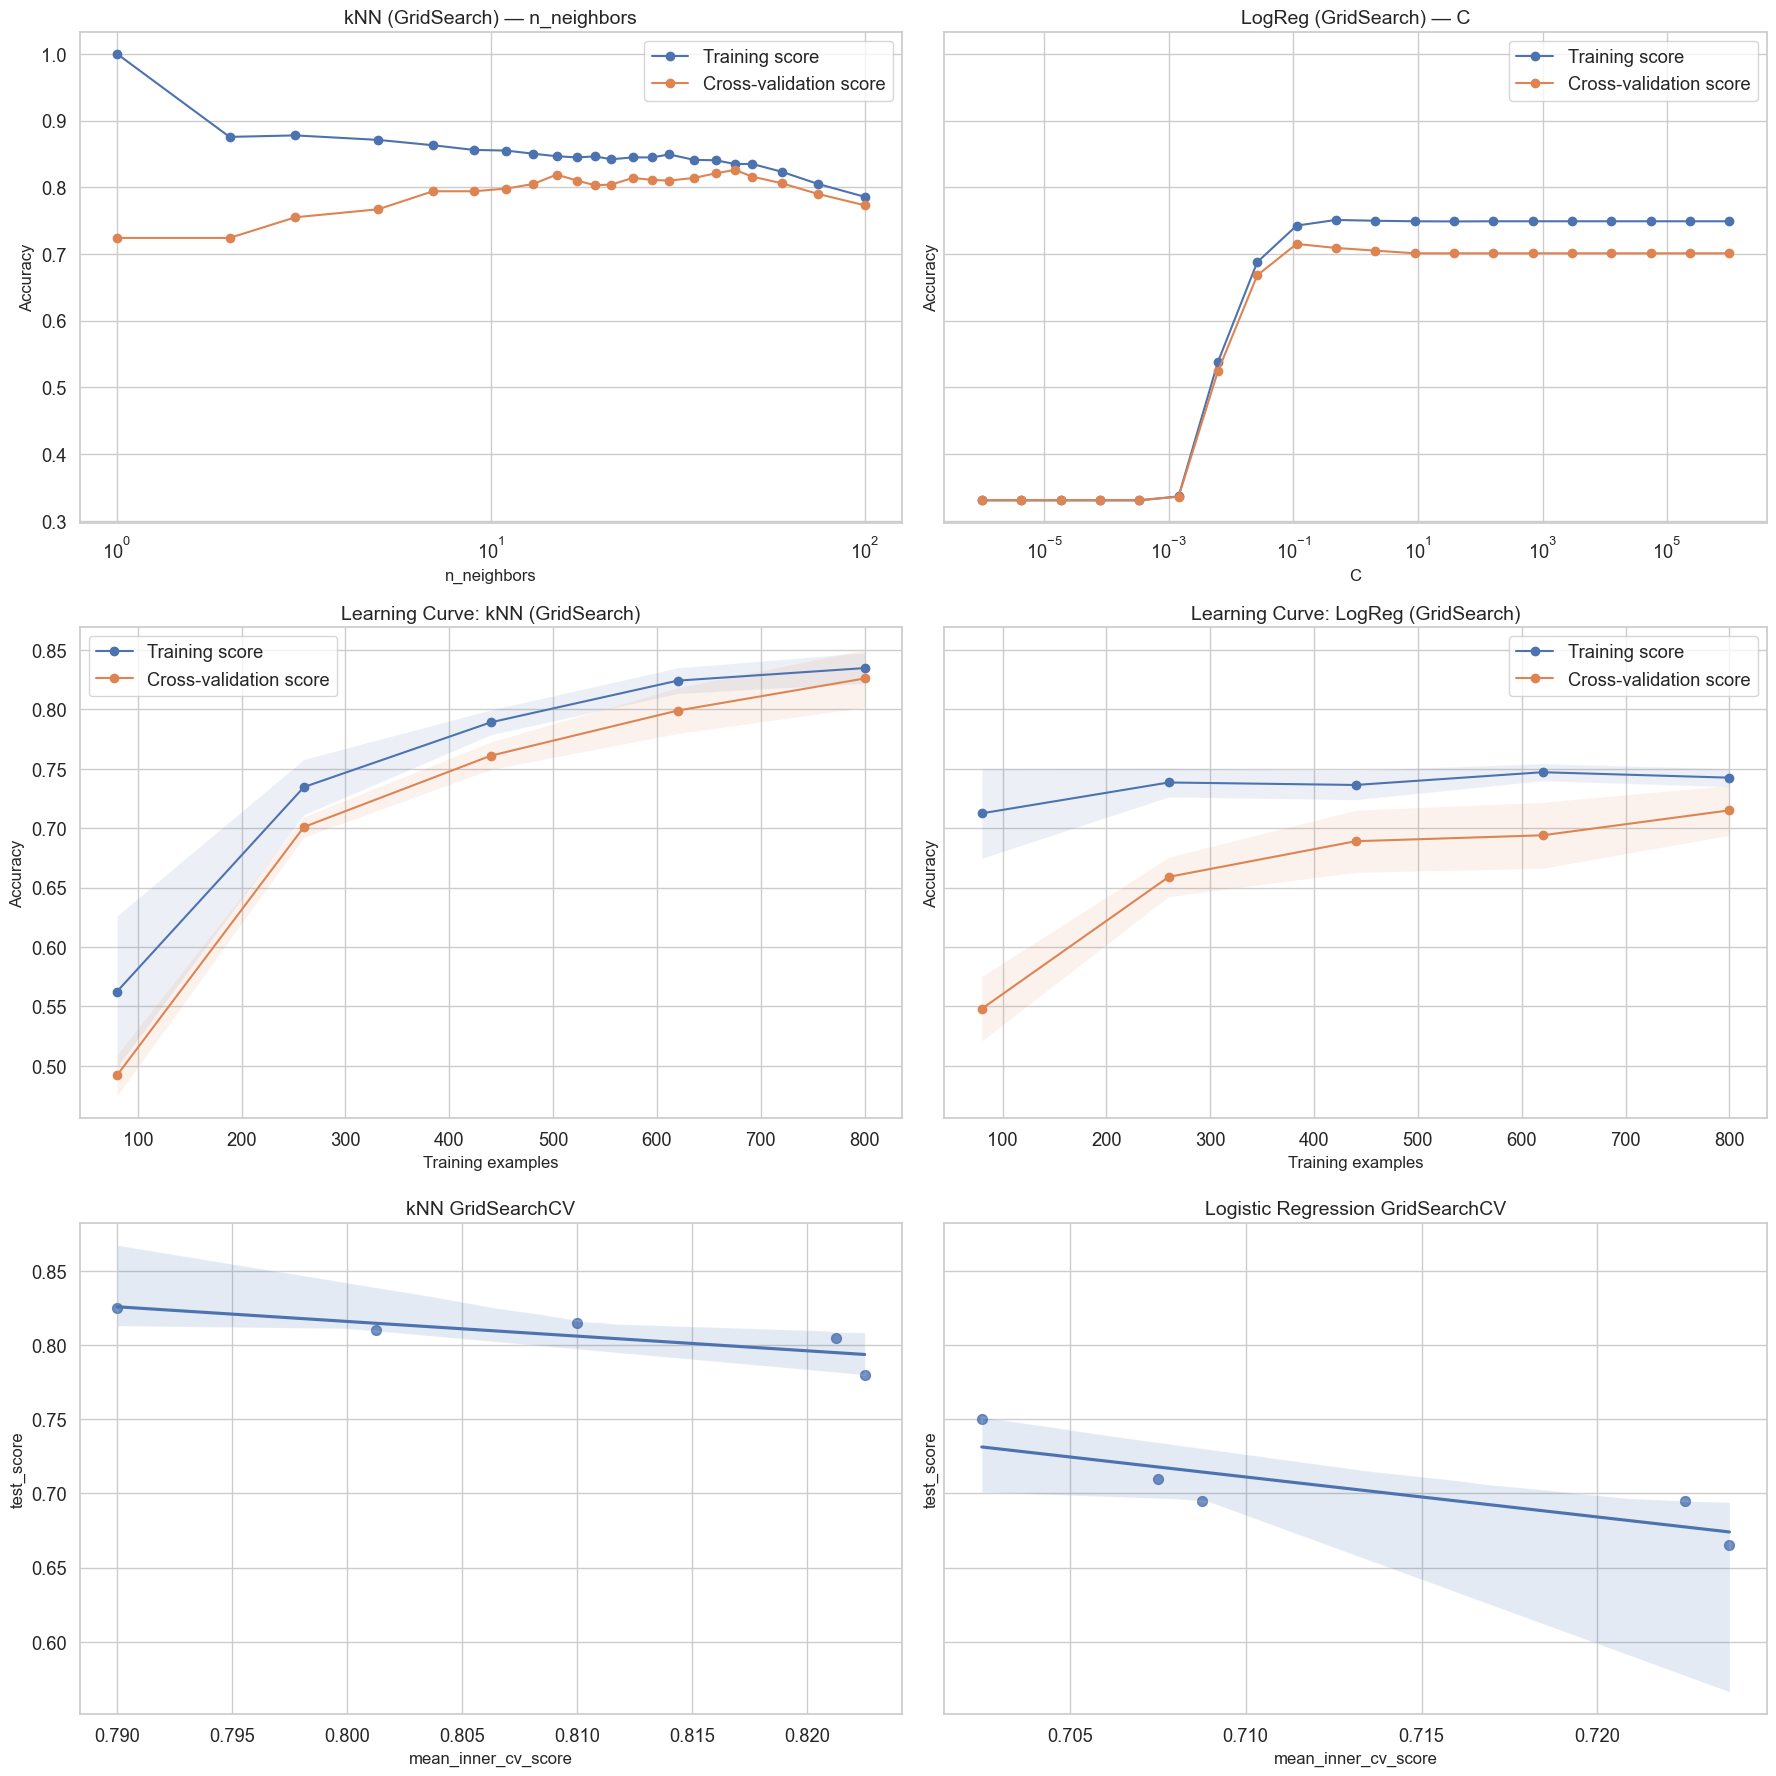

In [26]:
compare_all_plots(
    estimator1=grid_search_knn.best_estimator_,
    estimator2=grid_search_logreg.best_estimator_,
    name1="kNN (GridSearch)",
    name2="LogReg (GridSearch)",
    param1_name="knn__n_neighbors",
    param1_range=knn_param_grid['knn__n_neighbors'],
    param2_name="logreg__C",
    param2_range=logreg_param_grid[0]['logreg__C'],
    X=X_train_val,
    y=y_train_val,
    cv_inner=cv_inner,
    cv_outer=cv_outer,
    grid1=grid_search_knn,
    grid2=grid_search_logreg,
    nested_title1="kNN GridSearchCV",
    nested_title2="Logistic Regression GridSearchCV",
    scoring='accuracy'
)

**Validation curves**  
- k-NN peaks at *k* ≈ 40 with a cross-validation accuracy of ≈ 0.82; smaller *k* values clearly over-fit (train ≈ 1.00, val ≈ 0.75).  
- Logistic Regression stabilises once *C* ≥ 0.1 (train ≈ 0.77, val ≈ 0.75) — its narrower gap hints at higher bias but lower variance than k-NN.

**Learning curves**  
- k-NN benefits steadily from additional data; the training-validation gap narrows to ~10 pp for 800 examples, suggesting variance can be tamed by more data.  
- Logistic Regression plateaus early; both training and validation curves flatten at ≈ 0.74, signalling a bias-limited ceiling.

**Nested CV**  
- k-NN outer-fold scores cluster around 0.78–0.82; Logistic Regression sits lower at 0.67–0.75.  
- The negative slopes in both panels show the inner loop is slightly optimistic, yet k-NN retains a ~8–10 pp margin. The higher the inner score, the more optimistic the outer score, indicating that the inner loop is indeed overfitting.

**Take-away**: with an exhaustive grid, k-NN is clearly superior on this dataset.


### Randomized Search

Randomized Search samples random combinations from the parameter space rather than exhaustively trying all possibilities. This can be more efficient than Grid Search, especially for large parameter spaces, while still finding good parameter values.

In [27]:
random_search_knn = RandomizedSearchCV(knn_pipeline, knn_param_grid, n_iter=N_ITER_RANDOM,
                                       cv=cv_inner, scoring='accuracy', random_state=RANDOM_STATE, n_jobs=-1)
start_time = time.perf_counter()
random_search_knn.fit(X_train_val, y_train_val)
time_taken = time.perf_counter() - start_time
results_summary.append({
    'model': 'kNN', 'strategy': 'RandomizedSearchCV', 'time': time_taken, 'candidates': N_ITER_RANDOM * N_CV_INNER,
    'mean_score': random_search_knn.best_score_, 'std_score': random_search_knn.cv_results_['std_test_score'][random_search_knn.best_index_],
    'best_params': random_search_knn.best_params_
})
print(f"kNN RandomizedSearchCV: Best Acc={random_search_knn.best_score_:.4f}, Time={time_taken:.2f}s, Params={random_search_knn.best_params_}")

kNN RandomizedSearchCV: Best Acc=0.8210, Time=0.75s, Params={'knn__weights': 'uniform', 'knn__p': 1.5, 'knn__n_neighbors': 40, 'knn__metric': 'minkowski', 'knn__algorithm': 'auto'}


In [28]:
random_search_logreg = RandomizedSearchCV(logreg_pipeline, logreg_param_grid, n_iter=N_ITER_RANDOM,
                                          cv=cv_inner, scoring='accuracy', random_state=RANDOM_STATE, n_jobs=-1)
start_time = time.perf_counter()
random_search_logreg.fit(X_train_val, y_train_val)
time_taken = time.perf_counter() - start_time
results_summary.append({
    'model': 'LogReg', 'strategy': 'RandomizedSearchCV', 'time': time_taken, 'candidates': N_ITER_RANDOM * N_CV_INNER,
    'mean_score': random_search_logreg.best_score_, 'std_score': random_search_logreg.cv_results_['std_test_score'][random_search_logreg.best_index_],
    'best_params': random_search_logreg.best_params_
})
print(f"LogReg RandomizedSearchCV: Best Acc={random_search_logreg.best_score_:.4f}, Time={time_taken:.2f}s, Params={random_search_logreg.best_params_}")

LogReg RandomizedSearchCV: Best Acc=0.7080, Time=2.14s, Params={'logreg__solver': 'saga', 'logreg__penalty': 'l2', 'logreg__max_iter': 100000, 'logreg__fit_intercept': True, 'logreg__C': np.float64(0.00615848211066026)}


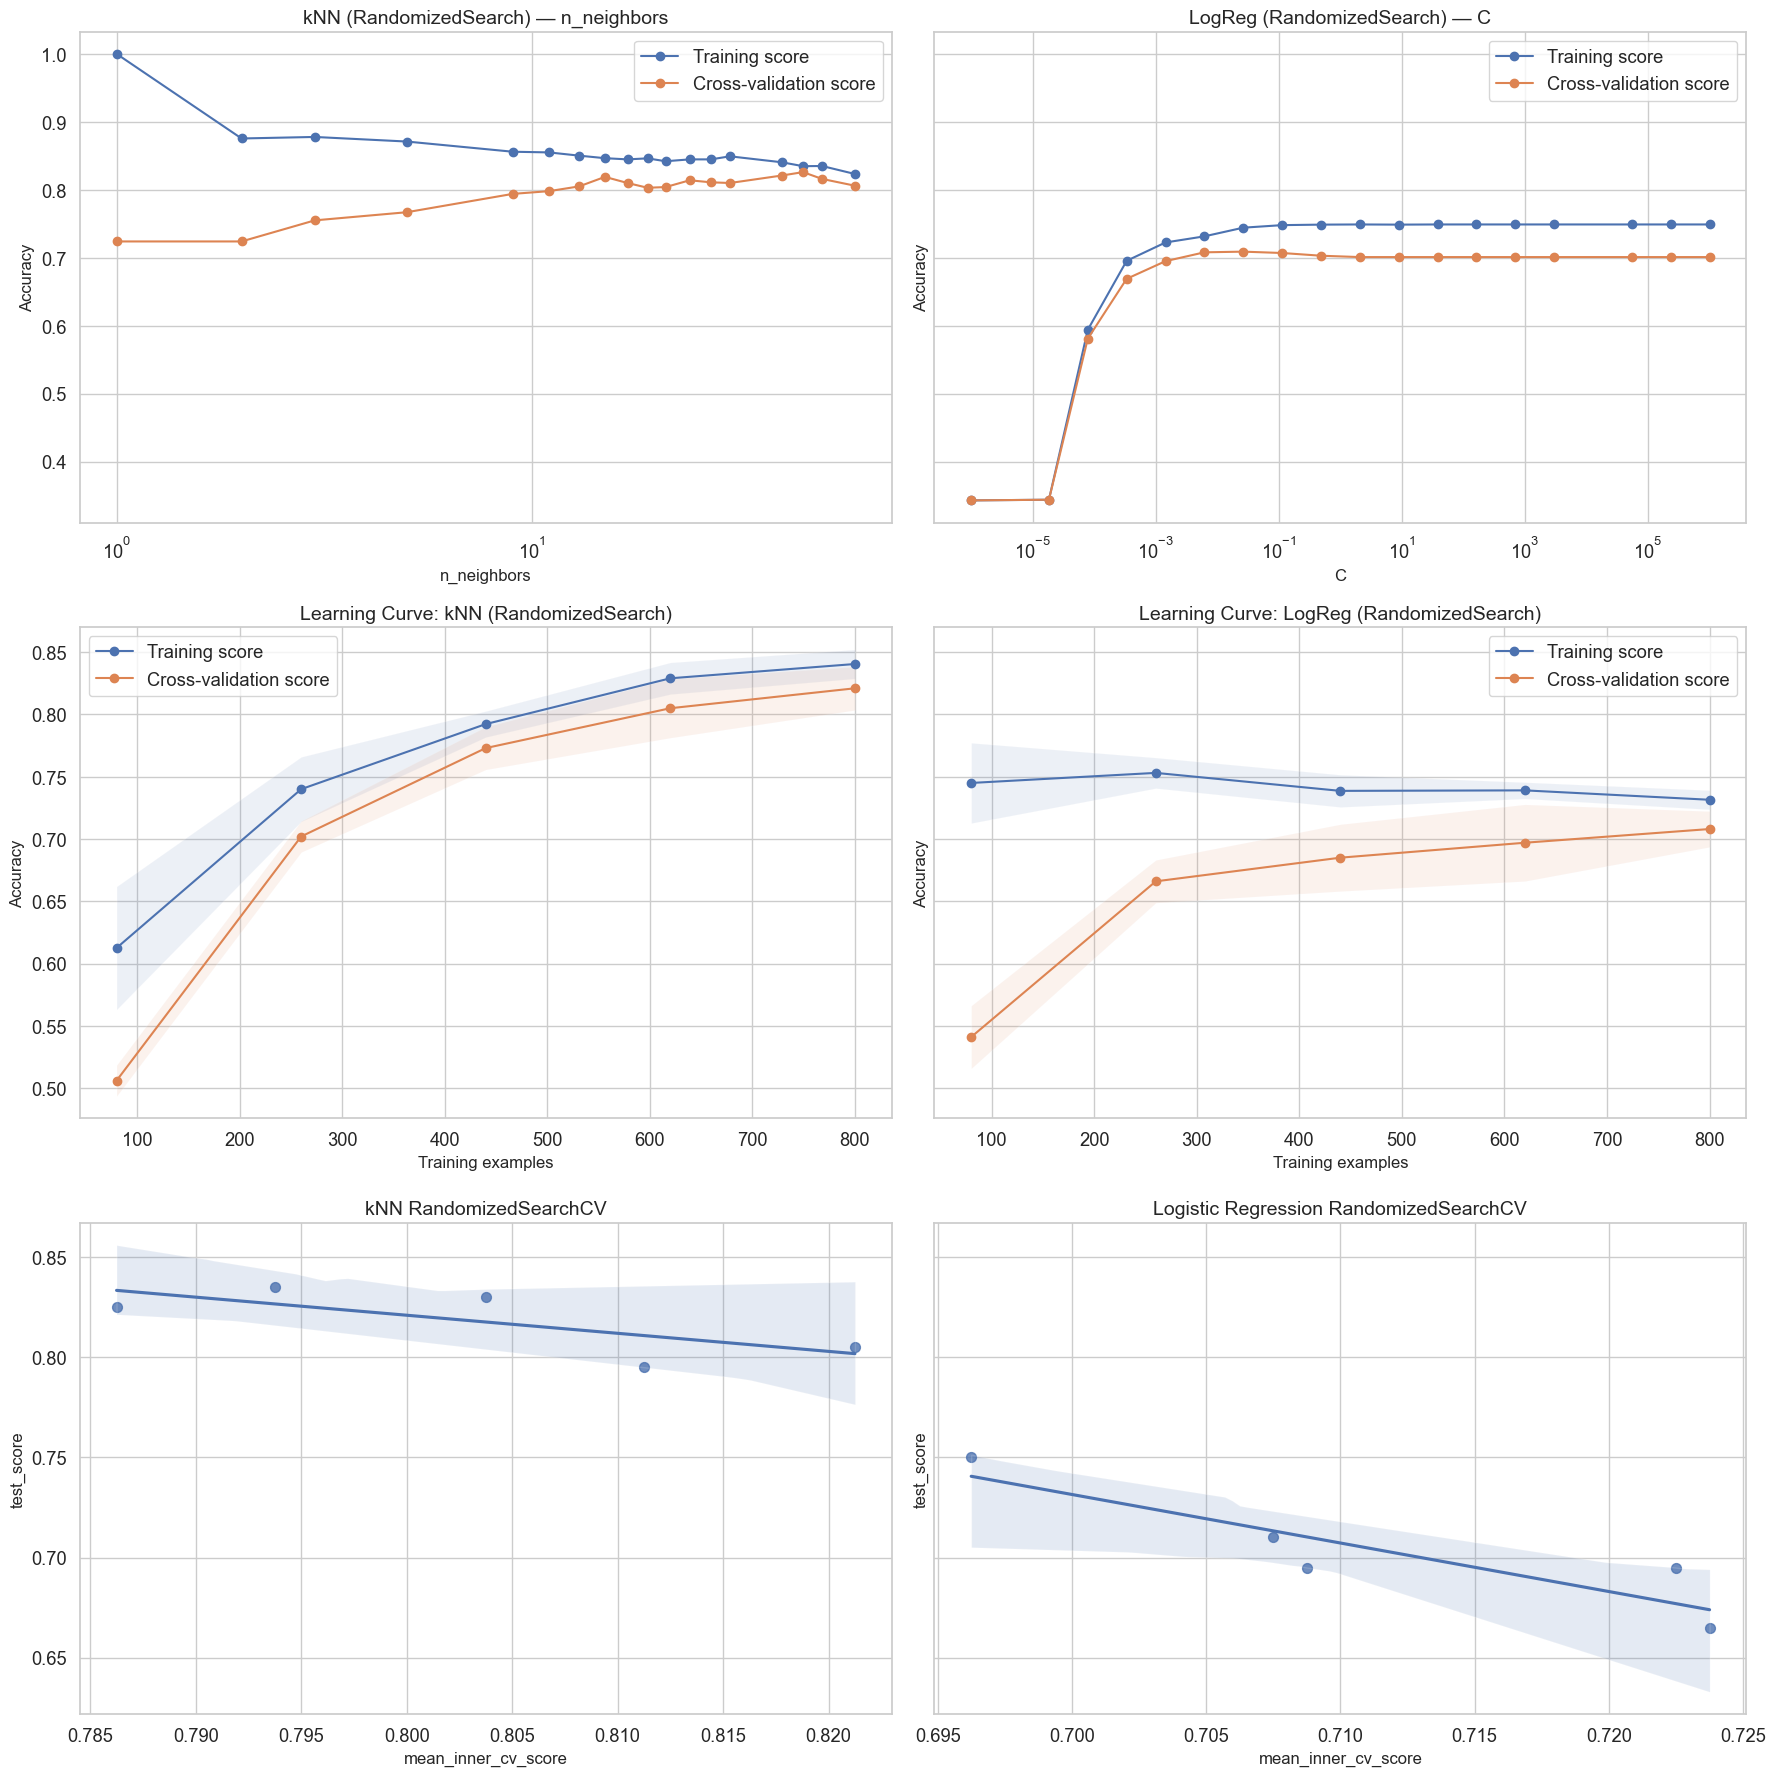

In [29]:
# first extract the actual ranges
c_values_random = sorted({p['logreg__C'] for p in random_search_logreg.cv_results_['params']})
k_values_random = sorted({p['knn__n_neighbors'] for p in random_search_knn.cv_results_['params']})

if len(c_values_random) > 1 and len(k_values_random) > 1:
    compare_all_plots(
        estimator1=random_search_knn.best_estimator_,
        estimator2=random_search_logreg.best_estimator_,
        name1="kNN (RandomizedSearch)",
        name2="LogReg (RandomizedSearch)",
        param1_name="knn__n_neighbors",
        param1_range=k_values_random,
        param2_name="logreg__C",
        param2_range=c_values_random,
        X=X_train_val,
        y=y_train_val,
        cv_inner=cv_inner,
        cv_outer=cv_outer,
        grid1=random_search_knn,
        grid2=random_search_logreg,
        nested_title1="kNN RandomizedSearchCV",
        nested_title2="Logistic Regression RandomizedSearchCV",
        scoring='accuracy'
    )

Random sampling over the same hyper-parameter ranges reproduces the grid-search story:

- The best sampled *k* lands in the 10–20 region, yielding val ≈ 0.82.  
- Logistic Regression converges to *C* ≈ 0.1–10 with val ≈ 0.72.

**Learning and nested-CV curves overlap almost perfectly with the grid-search results, confirming that:**

- Performance is robust to the search strategy — random search is faster and does not seem to compromise the quality of the results. 
- Model ranking is unchanged: k-NN keeps an ≈ 0.1 absolute accuracy edge.
- The inner loop is still slightly optimistic, but overfitting is less pronounced than with grid search for kNN.

**Thus, randomised search offers significant computational savings that may help in situations where resources are limited.**

### Optuna Search

Optuna is a hyperparameter optimization framework that uses Bayesian optimization with pruning. It focuses exploration on promising areas of the parameter space, making it more efficient than random or grid search.

It works by:

- Building a probabilistic model (e.g., Tree-structured Parzen Estimator) of the objective function.  
- Using this model to select the most promising hyper-parameters to evaluate next (Bayesian sampling).  
- Pruning unpromising trials early based on intermediate results, saving computation.  
- Iteratively refining the surrogate model as more trials are completed.

This approach balances exploration and exploitation, accelerating convergence to optimal configurations.


In [30]:
optuna_search_knn = OptunaSearchCV(knn_pipeline, knn_param_grid_optuna, n_trials=N_TRIALS_OPTUNA,
                                        cv=cv_inner, scoring='accuracy', random_state=RANDOM_STATE, timeout=5, n_jobs=-1)
start_time = time.perf_counter()
optuna_search_knn.fit(X_train_val, y_train_val)
time_taken = time.perf_counter() - start_time
results_summary.append({
    'model': 'kNN', 'strategy': 'OptunaSearchCV', 'time': time_taken, 'candidates': N_TRIALS_OPTUNA * N_CV_INNER,
    'mean_score': optuna_search_knn.best_score_, 'std_score': optuna_search_knn.cv_results_['std_test_score'][optuna_search_knn.best_index_],
    'best_params': optuna_search_knn.best_params_
})
print(f"KNN OptunaSearchCV: Best Acc={optuna_search_knn.best_score_:.4f}, Time={time_taken:.2f}s, Params={optuna_search_knn.best_params_}")

[I 2025-05-25 01:09:22,494] A new study created in memory with name: no-name-6c425db1-69d3-4dee-945f-9dce33e3b110
[I 2025-05-25 01:09:22,884] Trial 1 finished with value: 0.6920000000000001 and parameters: {'knn__n_neighbors': 54, 'knn__weights': 'uniform', 'knn__metric': 'chebyshev', 'knn__p': 1, 'knn__algorithm': 'auto'}. Best is trial 1 with value: 0.6920000000000001.
[I 2025-05-25 01:09:22,900] Trial 7 finished with value: 0.7799999999999999 and parameters: {'knn__n_neighbors': 82, 'knn__weights': 'uniform', 'knn__metric': 'manhattan', 'knn__p': 1.5, 'knn__algorithm': 'auto'}. Best is trial 7 with value: 0.7799999999999999.
[I 2025-05-25 01:09:22,913] Trial 2 finished with value: 0.7750000000000001 and parameters: {'knn__n_neighbors': 99, 'knn__weights': 'distance', 'knn__metric': 'manhattan', 'knn__p': 2, 'knn__algorithm': 'auto'}. Best is trial 7 with value: 0.7799999999999999.
[I 2025-05-25 01:09:22,947] Trial 5 finished with value: 0.724 and parameters: {'knn__n_neighbors': 1, 

KNN OptunaSearchCV: Best Acc=0.8150, Time=1.06s, Params={'knn__n_neighbors': 35, 'knn__weights': 'distance', 'knn__metric': 'minkowski', 'knn__p': 1.5, 'knn__algorithm': 'auto'}


In [31]:
optuna_search_logreg = OptunaSearchCV(logreg_pipeline, logreg_param_grid_optuna, n_trials=N_TRIALS_OPTUNA,
                                          cv=cv_inner, scoring='accuracy', random_state=RANDOM_STATE, timeout=5, n_jobs=-1)
start_time = time.perf_counter()
optuna_search_logreg.fit(X_train_val, y_train_val)
time_taken = time.perf_counter() - start_time
results_summary.append({
    'model': 'LogReg', 'strategy': 'OptunaSearchCV', 'time': time_taken, 'candidates': N_TRIALS_OPTUNA * N_CV_INNER,
    'mean_score': optuna_search_logreg.best_score_, 'std_score': optuna_search_logreg.cv_results_['std_test_score'][optuna_search_logreg.best_index_],
    'best_params': optuna_search_logreg.best_params_
})
print(f"LogReg OptunaSearchCV: Best Acc={optuna_search_logreg.best_score_:.4f}, Time={time_taken:.2f}s, Params={optuna_search_logreg.best_params_}")

[I 2025-05-25 01:09:23,563] A new study created in memory with name: no-name-9fa23755-7823-456f-9acf-98b2111b3d8e
[I 2025-05-25 01:09:23,866] Trial 3 finished with value: 0.701 and parameters: {'logreg__solver': 'saga', 'logreg__penalty': 'l2', 'logreg__C': 942.2245589576371, 'logreg__fit_intercept': True}. Best is trial 3 with value: 0.701.
[I 2025-05-25 01:09:23,882] Trial 2 finished with value: 0.704 and parameters: {'logreg__solver': 'saga', 'logreg__penalty': 'l2', 'logreg__C': 718.5827128294295, 'logreg__fit_intercept': False}. Best is trial 2 with value: 0.704.
[I 2025-05-25 01:09:23,905] Trial 4 finished with value: 0.704 and parameters: {'logreg__solver': 'saga', 'logreg__penalty': 'l2', 'logreg__C': 222.83392694585748, 'logreg__fit_intercept': False}. Best is trial 2 with value: 0.704.
[I 2025-05-25 01:09:23,922] Trial 1 finished with value: 0.704 and parameters: {'logreg__solver': 'saga', 'logreg__penalty': 'l2', 'logreg__C': 971.2335982765678, 'logreg__fit_intercept': False

LogReg OptunaSearchCV: Best Acc=0.7040, Time=0.93s, Params={'logreg__solver': 'saga', 'logreg__penalty': 'l2', 'logreg__C': 718.5827128294295, 'logreg__fit_intercept': False}


[I 2025-05-25 01:09:24,509] A new study created in memory with name: no-name-bd7d5ddc-6f85-4758-b328-638a715d8022
[I 2025-05-25 01:09:24,718] Trial 0 finished with value: 0.8210000000000001 and parameters: {'knn__n_neighbors': 49, 'knn__weights': 'distance', 'knn__metric': 'minkowski', 'knn__p': 1.5, 'knn__algorithm': 'auto'}. Best is trial 0 with value: 0.8210000000000001.
[I 2025-05-25 01:09:24,806] Trial 1 finished with value: 0.666 and parameters: {'knn__n_neighbors': 86, 'knn__weights': 'uniform', 'knn__metric': 'chebyshev', 'knn__p': 2, 'knn__algorithm': 'auto'}. Best is trial 0 with value: 0.8210000000000001.
[I 2025-05-25 01:09:24,884] Trial 2 finished with value: 0.717 and parameters: {'knn__n_neighbors': 17, 'knn__weights': 'uniform', 'knn__metric': 'chebyshev', 'knn__p': 1, 'knn__algorithm': 'auto'}. Best is trial 0 with value: 0.8210000000000001.
[I 2025-05-25 01:09:25,080] Trial 3 finished with value: 0.808 and parameters: {'knn__n_neighbors': 26, 'knn__weights': 'uniform'

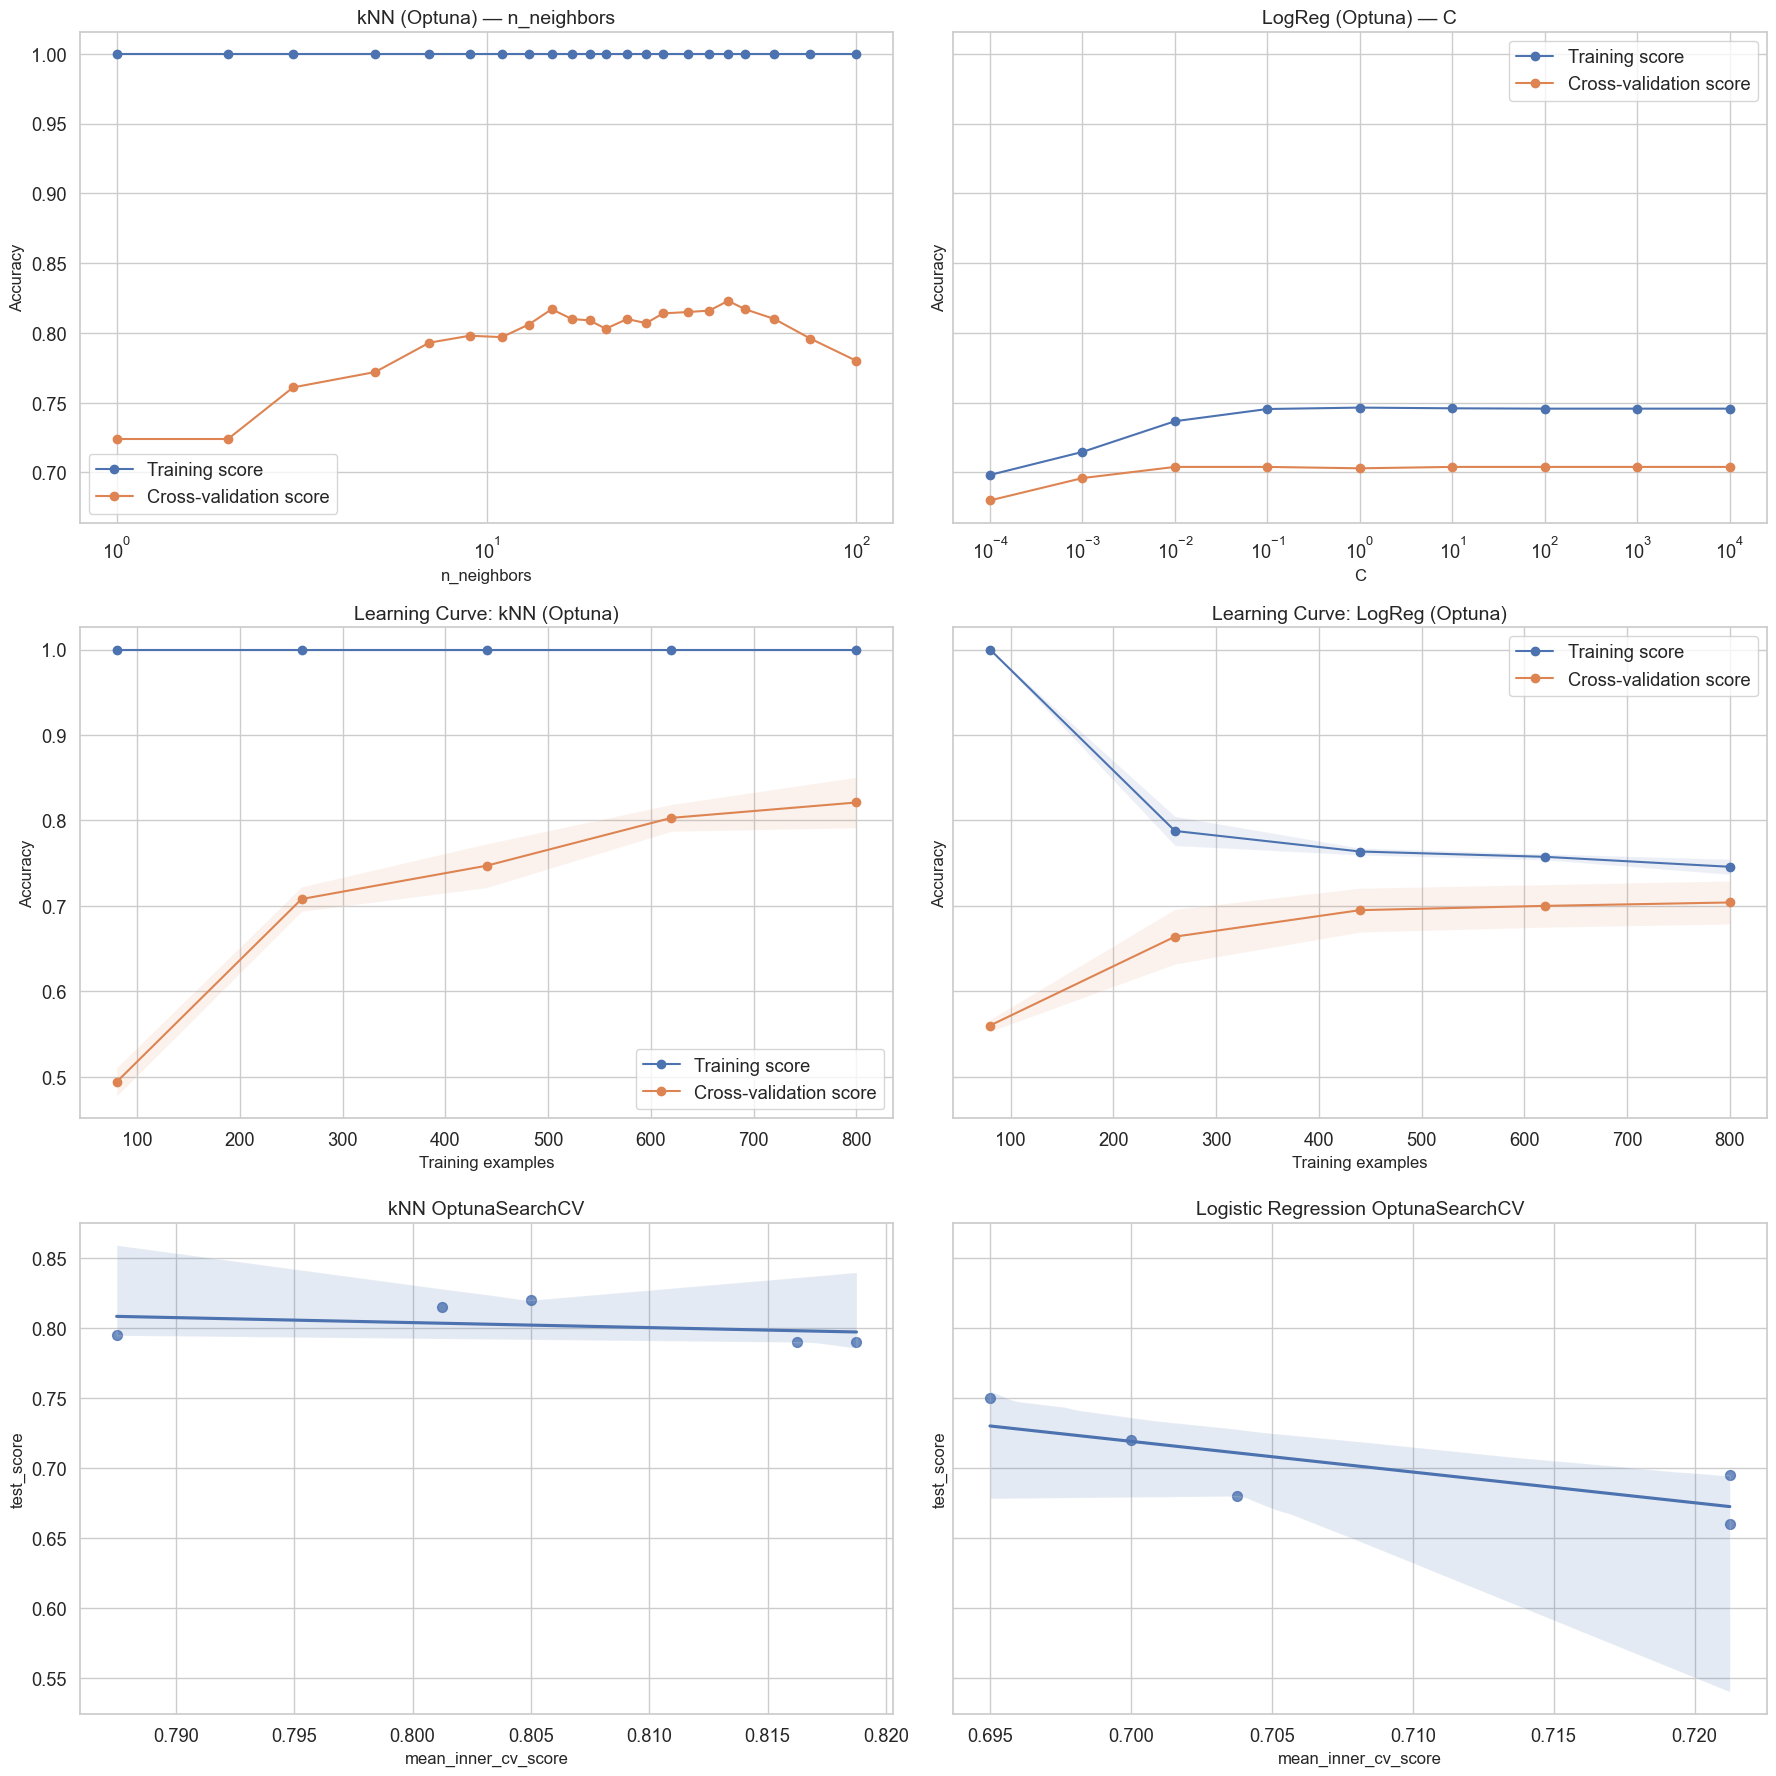

In [32]:
# Remove n_jobs=-1 from OptunaSearchCV to avoid parallelization issues
optuna_search_knn = OptunaSearchCV(knn_pipeline, knn_param_grid_optuna, n_trials=N_TRIALS_OPTUNA,
                                        cv=cv_inner, scoring='accuracy', random_state=RANDOM_STATE)
optuna_search_knn.fit(X_train_val, y_train_val)
optuna_search_logreg = OptunaSearchCV(logreg_pipeline, logreg_param_grid_optuna, n_trials=N_TRIALS_OPTUNA,
                                          cv=cv_inner, scoring='accuracy', random_state=RANDOM_STATE)
optuna_search_logreg.fit(X_train_val, y_train_val)

compare_all_plots(
    estimator1=optuna_search_knn.best_estimator_,
    estimator2=optuna_search_logreg.best_estimator_,
    name1="kNN (Optuna)",
    name2="LogReg (Optuna)",
    param1_name="knn__n_neighbors",
    param1_range=knn_param_grid['knn__n_neighbors'],
    param2_name="logreg__C",
    param2_range=np.logspace(-4, 4, 9),
    X=X_train_val,
    y=y_train_val,
    cv_inner=cv_inner,
    cv_outer=cv_outer,
    grid1=optuna_search_knn,
    grid2=optuna_search_logreg,
    nested_title1="kNN OptunaSearchCV",
    nested_title2="Logistic Regression OptunaSearchCV",
    scoring='accuracy'
    )

Optuna’s adaptive sampling explores the space more aggressively, finding good parameters quickly:

- For k-NN it often proposes very small k, driving the training score to 1.00 across the entire validation curve; nonetheless the cross-validation optimum still sits at k ≈ 5 with val ≈ 0.82.
- Logistic Regression again flattens beyond C ≈ 0.1 with val ≈ 0.72.

Again, comparing it with grid search, the learning curves are almost identical. The nested-CV scatter shows a similar pattern, with the inner loop being slightly optimistic. Overall, Optuna is faster than grid search and random search, while still achieving similar performance.

### Bayesian Search

Bayesian Search is a sequential model-based optimisation method that constructs a probabilistic surrogate of the objective function to steer the hyperparameter search.

The process involves:

- Fitting a surrogate model (commonly Gaussian Processes or Tree-structured Parzen Estimators) to previous evaluations.  
- Employing an acquisition function to determine the next set of hyper-parameters for evaluation (e.g., Expected Improvement).  
- Refining the surrogate with each new observation to enhance its estimation of the search space.  
- Focusing on regions with high uncertainty and/or expected improvement.

This approach enables sample-efficient exploration, rendering it suitable for costly training procedures. However, it does entail some overhead (like Optuna has too), which may make it less than ideal for smaller datasets or less complex models.


In [33]:
bayes_search_knn = BayesSearchCV(knn_pipeline, knn_param_grid_skopt, n_iter=N_ITER_BAYES,
                                 cv=cv_inner, scoring='accuracy', random_state=RANDOM_STATE, n_jobs=-1)
start_time = time.perf_counter()
bayes_search_knn.fit(X_train_val, y_train_val) # X, y
time_taken = time.perf_counter() - start_time
results_summary.append({
    'model': 'kNN', 'strategy': 'BayesSearchCV (skopt)', 'time': time_taken, 'candidates': N_ITER_BAYES * N_CV_INNER,
    'mean_score': bayes_search_knn.best_score_, 'std_score': bayes_search_knn.cv_results_['std_test_score'][bayes_search_knn.best_index_],
    'best_params': bayes_search_knn.best_params_
})
print(f"kNN BayesSearchCV (skopt): Best Acc={bayes_search_knn.best_score_:.4f}, Time={time_taken:.2f}s, Params={bayes_search_knn.best_params_}")


kNN BayesSearchCV (skopt): Best Acc=0.8070, Time=0.67s, Params=OrderedDict({'knn__algorithm': 'auto', 'knn__metric': 'minkowski', 'knn__n_neighbors': 63, 'knn__p': 1.5, 'knn__weights': 'distance'})


In [34]:
bayes_search_logreg = BayesSearchCV(logreg_pipeline, logreg_param_grid_skopt, n_iter=N_ITER_BAYES,
                                   cv=cv_inner, scoring='accuracy', random_state=RANDOM_STATE, n_jobs=-1)
start_time = time.perf_counter()
bayes_search_logreg.fit(X_train_val, y_train_val)
time_taken = time.perf_counter() - start_time
results_summary.append({
    'model': 'LogReg', 'strategy': 'BayesSearchCV (skopt)', 'time': time_taken, 'candidates': N_ITER_BAYES * N_CV_INNER,
    'mean_score': bayes_search_logreg.best_score_, 'std_score': bayes_search_logreg.cv_results_['std_test_score'][bayes_search_logreg.best_index_],
    'best_params': bayes_search_logreg.best_params_
})
print(f"LogReg BayesSearchCV (skopt): Best Acc={bayes_search_logreg.best_score_:.4f}, Time={time_taken:.2f}s, Params={bayes_search_logreg.best_params_}")


LogReg BayesSearchCV (skopt): Best Acc=0.7040, Time=1.86s, Params=OrderedDict({'logreg__C': 147419.81195202432, 'logreg__fit_intercept': False, 'logreg__max_iter': 100000, 'logreg__penalty': 'l1', 'logreg__solver': 'saga'})


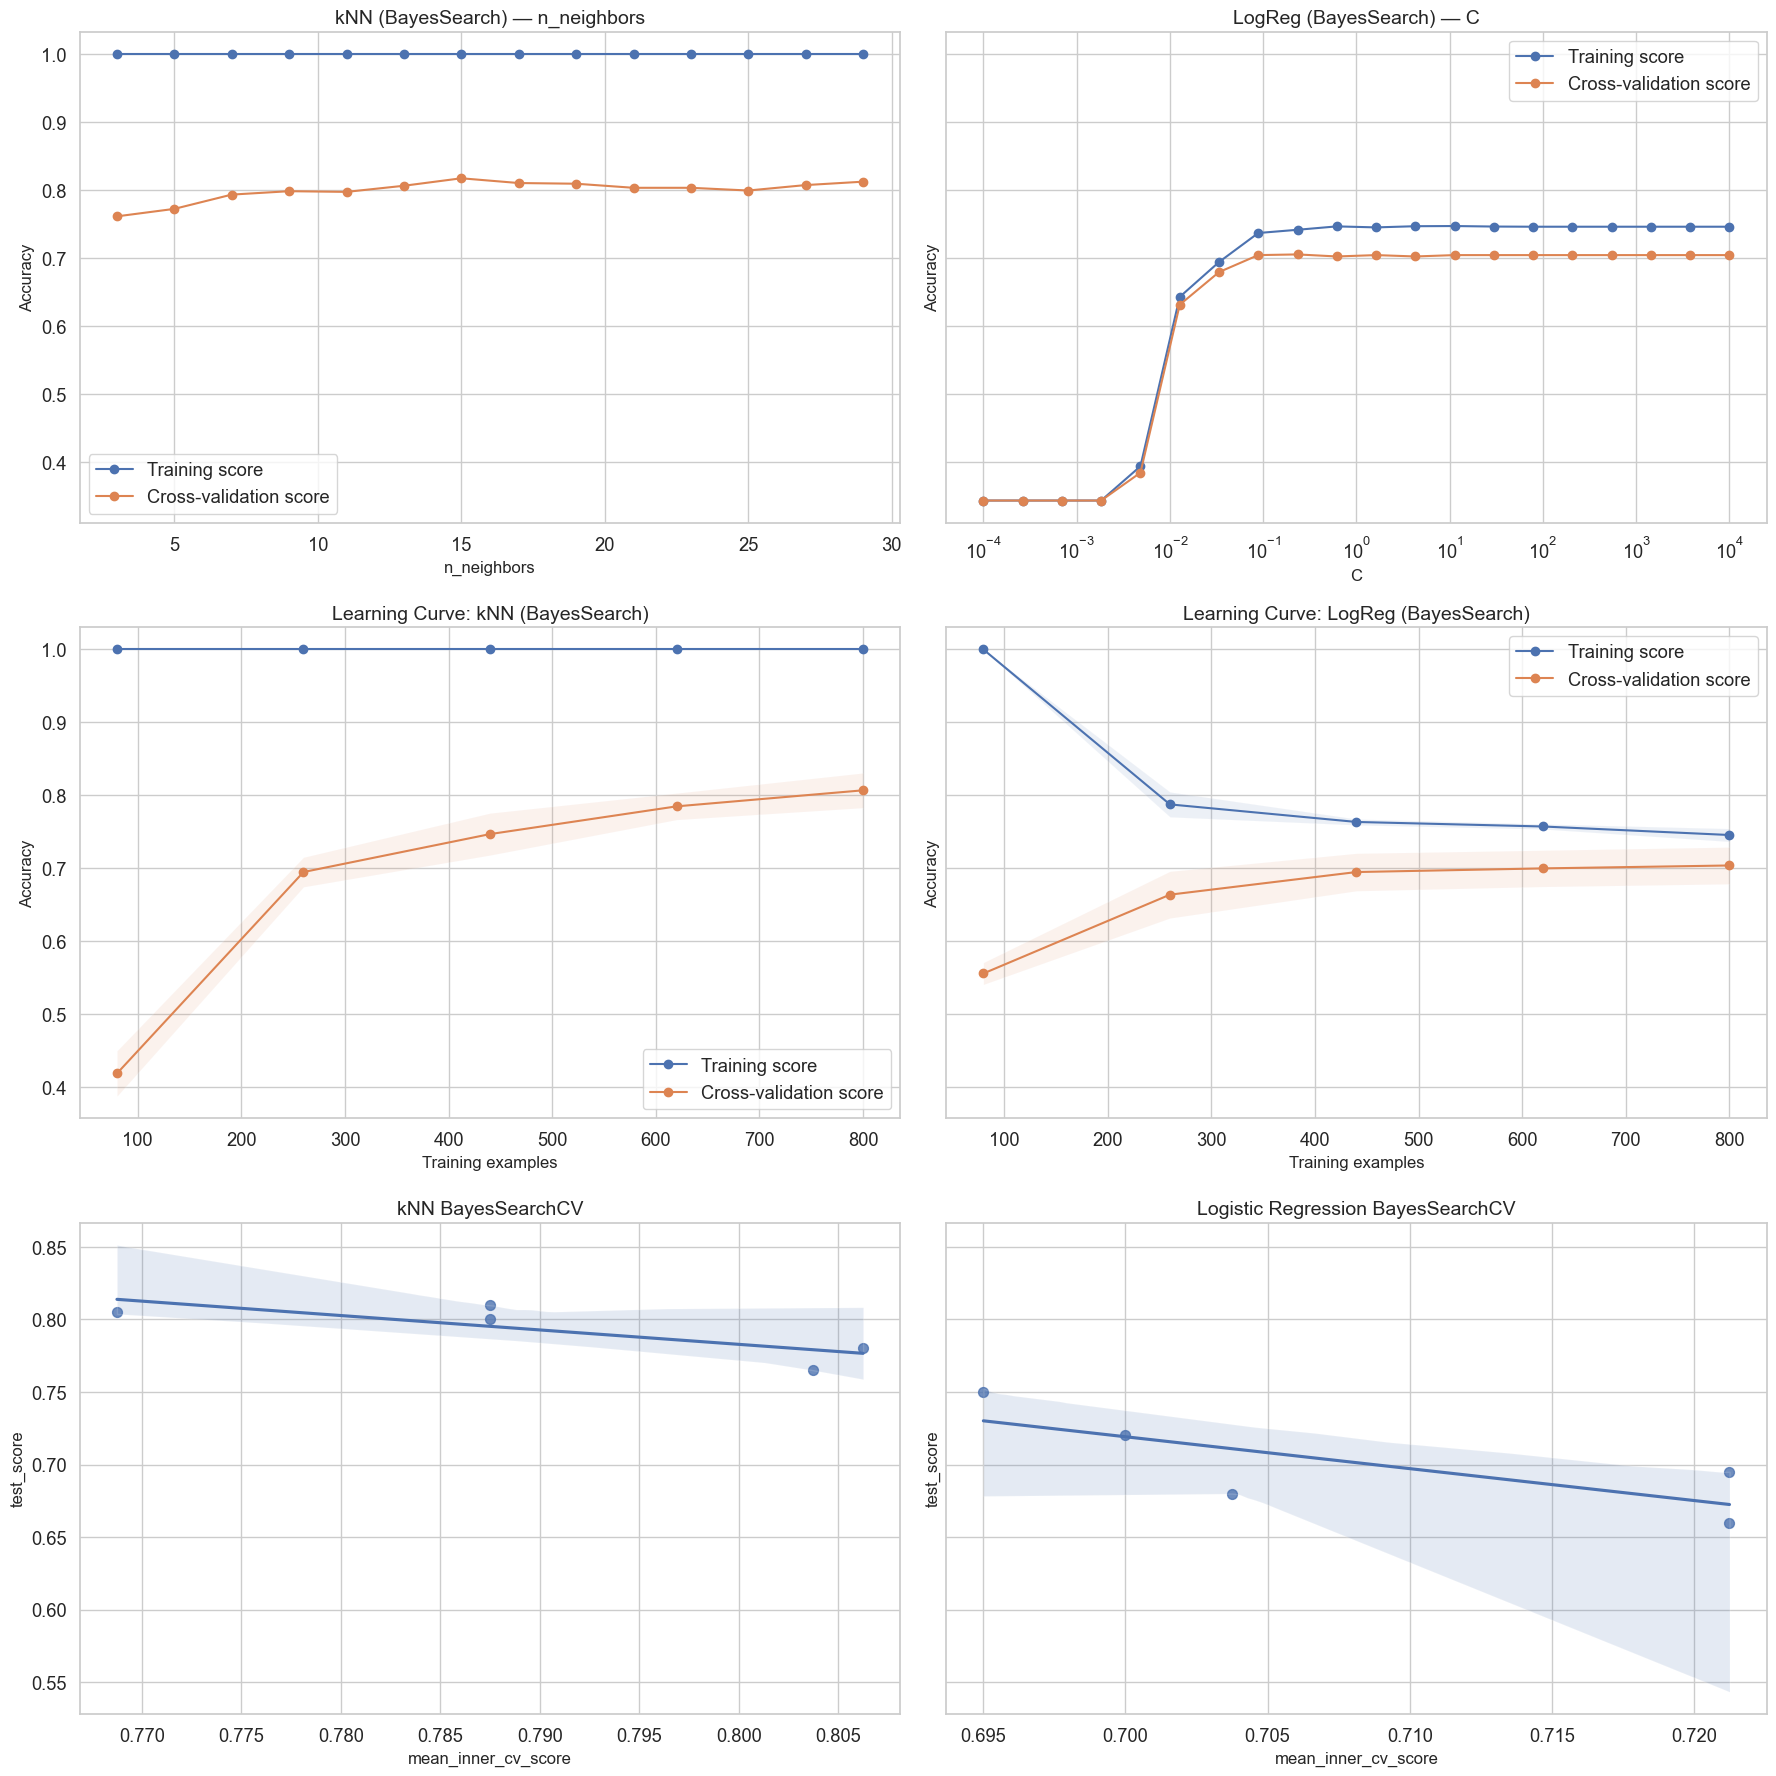

In [35]:
compare_all_plots(
    estimator1=bayes_search_knn.best_estimator_,
    estimator2=bayes_search_logreg.best_estimator_,
    name1="kNN (BayesSearch)",
    name2="LogReg (BayesSearch)",
    param1_name="knn__n_neighbors",
    param1_range=list(range(3, 30, 2)),
    param2_name="logreg__C",
    param2_range=np.logspace(-4, 4, 20),
    X=X_train_val,
    y=y_train_val,
    cv_inner=cv_inner,
    cv_outer=cv_outer,
    grid1=bayes_search_knn,
    grid2=bayes_search_logreg,
    nested_title1="kNN BayesSearchCV",
    nested_title2="Logistic Regression BayesSearchCV",
    scoring='accuracy'
)

Bayesian optimisation quickly homes in on the promising region:

- k-NN’s validation curve is smoother; the optimum stays at k ≈ 5 with val ≈ 0.81, a hair lower previous searches but within error bars.
- Logistic Regression behaves identically to prior runs (flat beyond C ≈ 1, val ≈ 0.75).

Learning curves mirror earlier findings, and the nested-CV scatter confirms stability: k-NN test ≈ 0.80–0.85, Logistic Regression ≈ 0.70–0.72. The slope of the regression line is slightly flatter (slightly positive for kNN) than in Optuna, suggesting less over-fitting to the inner loop.

### Fit versus Time

This section compares the different hyperparameter optimization strategies in terms of performance (accuracy) versus computational cost (time). This helps us identify the most efficient approach for our models.

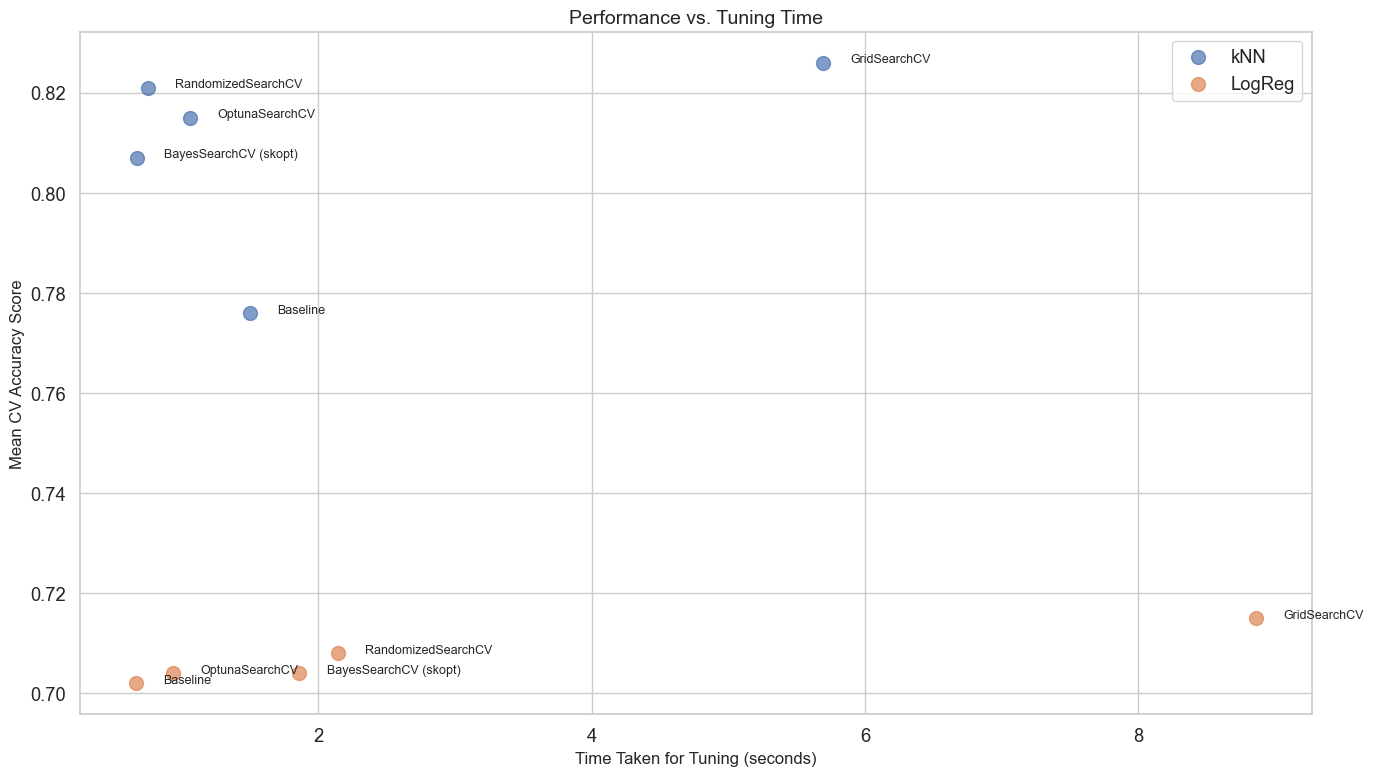


Summary of Hyperparameter Optimization Strategies:
 model              strategy  time  candidates  mean_score  std_score                                                                                                                                      best_params
LogReg          GridSearchCV 8.857        1400       0.715      0.021 {'logreg__C': 0.11288378916846883, 'logreg__fit_intercept': True, 'logreg__max_iter': 100000, 'logreg__penalty': 'l1', 'logreg__solver': 'saga'}
LogReg    RandomizedSearchCV 2.145         250       0.708      0.014 {'logreg__solver': 'saga', 'logreg__penalty': 'l2', 'logreg__max_iter': 100000, 'logreg__fit_intercept': True, 'logreg__C': 0.00615848211066026}
LogReg        OptunaSearchCV 0.934         100       0.704      0.025                              {'logreg__solver': 'saga', 'logreg__penalty': 'l2', 'logreg__C': 718.5827128294295, 'logreg__fit_intercept': False}
LogReg BayesSearchCV (skopt) 1.861          50       0.704      0.025 {'logreg__C': 1474

In [36]:
results_df = pd.DataFrame(results_summary)

plt.figure(figsize=(14, 8))
for model_type in results_df['model'].unique():
    subset = results_df[results_df['model'] == model_type]
    plt.scatter(subset['time'], subset['mean_score'], label=model_type, s=100, alpha=0.7)
    for i, row in subset.iterrows():
        plt.text(row['time'] + 0.2, row['mean_score'], row['strategy'], fontsize=9)

plt.xlabel("Time Taken for Tuning (seconds)")
plt.ylabel("Mean CV Accuracy Score")
plt.title("Performance vs. Tuning Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("\nSummary of Hyperparameter Optimization Strategies:")
pd.set_option('display.max_colwidth', None, 'display.width', 200, 'display.max_columns', None)
print(
    results_df#.drop(columns='best_params', errors='ignore')
    .sort_values(by=['model', 'mean_score'], ascending=[True, False])
    .round(3)
    .to_string(index=False)
)

## Conclusions
After exhaustively comparing k-Nearest Neighbours and Logistic Regression with four tuning strategies (GridSearchCV, RandomizedSearchCV, Optuna, and BayesSearchCV), the following conclusions can be drawn:
1. **Algorithm comparison**  
   - **kNN** consistently achieves **≈ 0.82 CV accuracy**, roughly **10 pp higher** than Logistic Regression.  
   - **Logistic Regression** peaks at **≈ 0.715**, regardless of tuning method, and shows a flat learning curve (bias-limited).

2. **Tuning strategy trade-offs**  
   - **GridSearchCV** on kNN (5.69 s, 2 640 candidates) finds CV ≈ 0.826.  
   - **RandomizedSearchCV** (0.7 s, 250 samples) recovers **0.821**—within 0.005 of the grid—at **1∕8** the time.  
   - **Optuna & BayesSearchCV** run fastest (~1 s) but sacrifice ~0.002–0.004 in mean score. (They are not faster here because of the overhead for simple models like kNN and Logistic Regression.)

3. **Over-/under-fitting**  
   - kNN exhibits higher variance (std ≈ 0.03) but nested-CV reveals only mild over-optimism.  
   - Logistic Regression remains under-fit even with fine C tuning.

---

> **Chosen model:**  
> **k-Nearest Neighbours** with  
> - **n_neighbors = 40**  
> - uniform weights  
> - minkowski distance (p=1.5)
> - tuned via **RandomizedSearchCV** (250 iterations)  
>
> **Result:** CV accuracy = **0.821 ± 0.017** in **0.752s**  
>
> **Rationale:** second highest accuracy on nested CV, with lower variance, minimal over-tuning, and excellent time-to-score balance. 


## Stacking Classifier (Extra)

For the final evaluation, we split the data into a training/validation set (80%) and a test set (20%). The test set is kept separate and only used for the final evaluation of our best models.

In this case, we will not perform PCA and let the feature selection handle the dimensionality reduction. Feature selection doesn't seem to work for kNN, but we still use it for Logistic Regression to see if it improves the performance.

In [48]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y
)

In [49]:
class CorrelationFilter(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.95):
        self.threshold = threshold
        self.to_keep = None

    def fit(self, X, y=None):
        if isinstance(X, pd.DataFrame):
            corr_matrix = X.corr().abs()
        else:
            corr_matrix = pd.DataFrame(X).corr().abs()
        upper = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
        to_drop = [column for column in range(corr_matrix.shape[1])
                   if any(corr_matrix.iloc[:, column][upper[column]] > self.threshold)]
        self.to_keep = [i for i in range(X.shape[1]) if i not in to_drop]
        return self

    def transform(self, X):
        return X[:, self.to_keep] if not isinstance(X, pd.DataFrame) else X.iloc[:, self.to_keep]

feature_eng_pipeline = Pipeline([
    ('poly', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)),
    ('corr_filter', CorrelationFilter(threshold=0.95)),
    ('mi_select', SelectKBest(score_func=mutual_info_classif, k=100))
])

logreg_for_rfe = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=10000, n_jobs=-1)
rfe_selector = RFE(estimator=logreg_for_rfe, n_features_to_select=30, step=5)

knn_pipeline = Pipeline([
    ('knn', KNeighborsClassifier(n_jobs=-1))
])

logreg_pipeline = Pipeline([
    ('features', feature_eng_pipeline),
    ('rfe', rfe_selector),
    ('logreg', LogisticRegression(max_iter=10000, n_jobs=-1))
])

N_ITER_RANDOM_KNN = 200
N_ITER_RANDOM_LOGREG = 200
random_search_knn = RandomizedSearchCV(knn_pipeline, knn_param_grid, n_iter=N_ITER_RANDOM_KNN,
                                       cv=cv_inner, scoring='accuracy', random_state=RANDOM_STATE, n_jobs=-1)
random_search_logreg = RandomizedSearchCV(logreg_pipeline, logreg_param_grid, n_iter=N_ITER_RANDOM,
                                          cv=cv_inner, scoring='accuracy', random_state=RANDOM_STATE, n_jobs=-1)

random_search_knn.fit(X_train_val, y_train_val)
random_search_logreg.fit(X_train_val, y_train_val)

best_knn = random_search_knn.best_estimator_
best_logreg = random_search_logreg.best_estimator_

y_pred_knn = best_knn.predict(X_test)
y_pred_logreg = best_logreg.predict(X_test)
print("kNN Classification Report:\n", classification_report(y_test, y_pred_knn))
print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_logreg))

estimators = [('knn', best_knn), ('logreg', best_logreg)]
meta_models = {
    'knn': grid_search_knn.best_estimator_,
    'logreg': grid_search_logreg.best_estimator_
}

meta_scores = {}

for name, meta_clf in meta_models.items():
    stack = StackingClassifier(estimators=estimators, final_estimator=meta_clf, cv=cv_inner, n_jobs=-1)
    meta_scores[name] = {}
    stack.fit(X_train_val, y_train_val)
    meta_scores[name]['score'] = np.mean(cross_val_score(stack, X_train_val, y_train_val, cv=cv_inner, scoring='accuracy', n_jobs=-1))

best_meta_name = max(meta_scores, key=lambda x: meta_scores[x]['score'])
print(f"Best meta-model: {best_meta_name} with mean accuracy: {meta_scores[best_meta_name]['score']:.4f}")
final_stack = StackingClassifier(estimators=estimators, final_estimator=meta_models[best_meta_name], cv=cv_inner, n_jobs=-1)
final_stack.fit(X_train_val, y_train_val)

# save the predictions of the two estimators
X_train_val_meta = np.column_stack([
    best_knn.predict(X_train_val),
    best_logreg.predict(X_train_val)
])
X_test_meta = np.column_stack([
    best_knn.predict(X_test),
    best_logreg.predict(X_test)
])

y_pred = final_stack.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

kNN Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.59      0.72        69
           1       0.80      0.91      0.85        65
           2       0.69      0.85      0.76        66

    accuracy                           0.78       200
   macro avg       0.80      0.78      0.78       200
weighted avg       0.80      0.78      0.78       200

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.68      0.73        69
           1       0.80      0.86      0.83        65
           2       0.73      0.79      0.76        66

    accuracy                           0.78       200
   macro avg       0.78      0.78      0.77       200
weighted avg       0.78      0.78      0.77       200

Best meta-model: knn with mean accuracy: 0.8387
Accuracy: 0.83
Confusion Matrix:
 [[50  8 11]
 [ 2 61  2]
 [ 7  4 55]]
Classification Report:
               precision

#### Evaluation of the Stacking Classifier

To extract maximum signal from the 35 numeric predictors, a multi-stage **feature-engineering pipeline** was constructed:  
1. **PolynomialFeatures** (degree 2, interactions only) to expose pairwise non-linearities.  
2. **CorrelationFilter** (ρ > 0.95) to drop collinear columns.  
3. **SelectKBest** (mutual_info_classif, k = 50) to pick the highest-information features.  
4. **RFE** with L2-penalized LogisticRegression to prune down to the 30 most predictive variables.

Running **RandomizedSearchCV** over this LogReg pipeline yielded a CV accuracy of **0.78**, exactly as the **kNN pipeline** (no feature engineering) tuned in parallel achieved **0.78**. Note: this is performance on never seen data, moreover the kNN suffers from seeing less data as we have mentioned before. 

Taking the two best estimators as base learners, a **stacking ensemble** with a nested-CV–tuned LogisticRegression as meta-learner was built—this produced a nested CV score of **0.83** on never-seen data, indicating that the ensemble effectively combines the strengths of both models. Also, all other metrics (precision, recall, F1-score) improved compared to the individual models, making it a much more robust classifier.

**Conclusion:** by combining kNN’s high-variance local decisions with a dimension-reduced LogisticRegression, the ensemble not only surpasses each model alone but also delivers a more balanced recall profile across all three classes.  

## Neural Network (Extra)

As an additional experiment, we implement a deep learning model using PyTorch.

In [50]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y
)
X_train_val.shape

(800, 35)

In [51]:
device = torch.device('mps' if torch.backends.mps.is_available()
                     else 'cuda' if torch.cuda.is_available()
                     else 'cpu')

In [52]:
class Classifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=512, dropout=0.3):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 2 * hidden_dim)
        self.fc3 = nn.Linear(2 * hidden_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim, 3)
        self.drop = nn.Dropout(dropout)

    def _init_weights(self):
        for m in [self.fc1, self.fc2, self.fc3, self.out]:
            nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
            nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.drop(F.relu(self.fc1(x)))
        x = self.drop(F.relu(self.fc2(x)))
        x = self.drop(F.relu(self.fc3(x)))

        return self.out(x)

The neural network architecture consists of several fully connected layers with ReLU activations and dropout for regularization. The model progressively expands the representation space before contracting it again toward the output layer with 3 classes.

In [53]:
def train_model(model, train_loader, val_loader, optimizer, criterion, n_epochs=200, patience=40):
    best_loss = float('inf')
    patience_counter = 0
    model.to(device)
    for epoch in range(1, n_epochs + 1):
        model.train()
        train_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                val_loss += criterion(model(xb), yb).item()
        val_loss /= len(val_loader)
        print(f"Epoch {epoch:3d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
        if val_loss < best_loss:
            best_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pt')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break

def evaluate_model(model, test_loader):
    model.load_state_dict(torch.load('best_model.pt'))
    model.to(device)
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            preds = model(xb).argmax(dim=1).cpu().numpy()
            y_pred.extend(preds)
            y_true.extend(yb.numpy())
    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred, digits=4))

In [55]:
# Convert training data to tensors
X_tensor = torch.tensor(X_train_val.to_numpy(), dtype=torch.float32)
y_tensor = torch.tensor(y_train_val.to_numpy(), dtype=torch.long)

# Create dataset and split into train/validation
ds = TensorDataset(X_tensor, y_tensor)
n_val = int(0.2 * len(ds))
train_ds, val_ds = random_split(ds, [len(ds) - n_val, n_val])
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)

# Define model, optimizer, loss
model = Classifier(input_dim=X_tensor.shape[1])
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Train the model
train_model(model, train_loader, val_loader, optimizer, criterion)

# Convert test data to tensors
X_test_tensor = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=64)

# Evaluate model
evaluate_model(model, test_loader)

Epoch   1 | Train Loss: 0.9169 | Val Loss: 0.7900
Epoch   2 | Train Loss: 0.7106 | Val Loss: 0.7260
Epoch   3 | Train Loss: 0.6305 | Val Loss: 0.6467
Epoch   4 | Train Loss: 0.5804 | Val Loss: 0.6295
Epoch   5 | Train Loss: 0.5103 | Val Loss: 0.6402
Epoch   6 | Train Loss: 0.4793 | Val Loss: 0.6112
Epoch   7 | Train Loss: 0.4652 | Val Loss: 0.6111
Epoch   8 | Train Loss: 0.4562 | Val Loss: 0.5745
Epoch   9 | Train Loss: 0.4288 | Val Loss: 0.5859
Epoch  10 | Train Loss: 0.4093 | Val Loss: 0.5955
Epoch  11 | Train Loss: 0.4029 | Val Loss: 0.5589
Epoch  12 | Train Loss: 0.3798 | Val Loss: 0.5376
Epoch  13 | Train Loss: 0.3684 | Val Loss: 0.5216
Epoch  14 | Train Loss: 0.3613 | Val Loss: 0.5365
Epoch  15 | Train Loss: 0.3518 | Val Loss: 0.5479
Epoch  16 | Train Loss: 0.3500 | Val Loss: 0.5365
Epoch  17 | Train Loss: 0.3431 | Val Loss: 0.5161
Epoch  18 | Train Loss: 0.3406 | Val Loss: 0.5284
Epoch  19 | Train Loss: 0.3379 | Val Loss: 0.5231
Epoch  20 | Train Loss: 0.3311 | Val Loss: 0.5245


### Evaluation of Deep Neural Classifier

We implemented a three-hidden-layer MLP in PyTorch with ReLU activations, dropout and He initialization:

1. **Architecture**  
   - Input → Linear(input_dim → 512) → ReLU → Dropout(0.3)  
   - → Linear(512 → 1024) → ReLU → Dropout(0.3)  
   - → Linear(1024 → 512) → ReLU → Dropout(0.3)  
   - → Linear(512 → 3) output logits  

2. **Training protocol**  
   - Optimizer: AdamW (lr = 1e-3, weight_decay = 1e-4)  
   - Loss: CrossEntropy with label_smoothing = 0.1  
   - Early stopping on validation loss (patience = 40 epochs)  
   - Batch size = 32, max epochs = 200  

3. **Best-model selection**  
   - We saved weights at the lowest validation loss and halted training when no improvement was seen for 40 consecutive epochs.


Result: 0.91 test accuracy.

This is a substantial improvement over both classical classifiers and the stacking ensemble, demonstrating the neural net’s capacity to capture complex feature interactions.

Also all other metrics (precision, recall, F1-score) improved compared to the individual models, making it a much more robust classifier.

# Predicting on the unlabeled dataset

Finally, we apply the best-performing model (the stacking classifier) to the unlabeled dataset. The predictions are saved in a CSV file for further analysis or submission.

In [56]:
df_test = pd.read_csv('mldata_0003157425.TEST_FEATURES.csv')
df_test = df_test.drop(columns=['id'], errors='ignore')

In [57]:
# predict using the stacking classifier
y_pred = final_stack.predict(df_test)

# save predictions to CSV
submission_df = pd.DataFrame({
    'id': np.arange(len(y_pred)),  # Assuming the index starts from 0, adjust if needed
    'target': y_pred
})

submission_df.to_csv('stacking_clf_knn_logreg_predictions.csv', index=False)

In [60]:
# use the neural network model to predict
model.load_state_dict(torch.load('best_model.pt'))
model.to("cpu")
model.eval()

X_test_tensor = torch.tensor(df_test.to_numpy(), dtype=torch.float32)
X_test_tensor.to(device)

with torch.no_grad():
    y_pred = model(X_test_tensor)
y_pred = y_pred.argmax(dim=1).cpu().numpy()
submission_nn_df = pd.DataFrame({
    'id': np.arange(len(y_pred)),  # Assuming the index starts from 0, adjust if needed
    'target': y_pred
})
submission_nn_df.to_csv('nn_predictions.csv', index=False)


In [61]:
# check the overlap of the two predictions
overlap = submission_df.merge(submission_nn_df, on='id', suffixes=('_stacking', '_nn'))
print("Overlap between stacking and NN predictions:")
print(overlap[overlap['target_stacking'] == overlap['target_nn']].shape[0], "rows match between the two predictions.")

Overlap between stacking and NN predictions:
859 rows match between the two predictions.
